In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from typing import List, Tuple, Dict
from pathlib import Path
from math import ceil
import os
from datetime import datetime
project_root = Path.cwd().parent.parent 
print(project_root)
sys.path.append(str(project_root))


data = pd.read_csv(f"{project_root}/data/all_leagues_combined.csv")
data.head()

/media/l1t-w1n/E/footwork/FootWork


date        season          home_team          away_team  \
0  2017-08-27 12:30:00  2017-to-2018            Chelsea            Everton   
1  2017-08-27 15:00:00  2017-to-2018          Liverpool            Arsenal   
2  2017-08-27 15:00:00  2017-to-2018  Tottenham Hotspur            Burnley   
3  2017-09-09 11:30:00  2017-to-2018    Manchester City          Liverpool   
4  2017-09-09 14:00:00  2017-to-2018            Everton  Tottenham Hotspur   

  target_result  target_home_goals  target_away_goals  home_games_played  \
0       HomeWin                  2                  0                  2   
1       HomeWin                  4                  0                  2   
2          Draw                  1                  1                  2   
3       HomeWin                  5                  0                  3   
4       AwayWin                  0                  3                  3   

   home_wins  home_draws  ...  away_avg_reds  away_cards_first_half_ratio  \
0        1.0         0.0  ...            0.5                     0.400000   
1        1.0         1.0  ...            0.0                     0.000000   
2        1.0         0.0  ...            0.0                     0.000000   
3        2.0         1.0  ...            0.0                     0.500000   
4        1.0         1.0  ...            0.0                     0.333333   

   away_venue_games  away_venue_win_ratio  away_venue_goals_avg  \
0                 1                   0.0                   1.0   
1                 1                   0.0                   0.0   
2                 1                   1.0                   3.0   
3                 1                   0.0                   3.0   
4                 1                   1.0                   2.0   

   away_venue_conceded_avg  away_clean_sheets_ratio  away_scoring_ratio  \
0                      1.0                 0.500000                 1.0   
1                      1.0                 0.000000                 0.5   
2                      2.0                 0.000000                 0.5   
3                      3.0                 0.666667                 1.0   
4                      0.0                 0.333333                 1.0   

   away_comeback_ratio  away_lead_loss_ratio  
0                  0.0                   0.0  
1                  0.0                   0.0  
2                  0.0                   0.0  
3                  0.0                   0.0  
4                  0.0                   0.0  

[5 rows x 75 columns]

In [9]:
def create_feature_groups(columns: List[str]) -> dict:
    """
    Organizes features into logical groups for more structured analysis.
    Each group represents a different aspect of football matches.
    """
    groups = {
        'match_info': ['date', 'season', 'home_team', 'away_team'],
        'target_variables': ['target_result', 'target_home_goals', 'target_away_goals'],
        'performance_metrics': [col for col in columns if any(x in col for x in ['wins', 'draws', 'losses', 'points', 'games_played'])],
        'goal_stats': [col for col in columns if 'goals' in col and 'target' not in col],
        'shot_stats': [col for col in columns if 'shot' in col],
        'possession_stats': [col for col in columns if 'possession' in col],
        'set_pieces': [col for col in columns if 'corner' in col],
        'disciplinary': [col for col in columns if any(x in col for x in ['foul', 'yellow', 'red', 'card'])],
        'venue_specific': [col for col in columns if 'venue' in col],
        'form_indicators': [col for col in columns if any(x in col for x in ['ratio', 'recent', 'efficiency'])]
    }
    return groups

def ensure_folder_exists(base_folder: str) -> str:
    """
    Creates a folder structure for saving plots with timestamp.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_path = os.path.join(base_folder, f"football_analysis_{timestamp}")
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created analysis folder: {folder_path}")
    return folder_path

def calculate_optimal_dpi(fig, max_pixels=8000):
    """
    Calculates the optimal DPI for saving a figure while staying under max_pixels dimensions.
    """
    width_inches, height_inches = fig.get_size_inches()
    width_dpi = max_pixels / width_inches
    height_dpi = max_pixels / height_inches
    optimal_dpi = int(min(width_dpi, height_dpi))
    
    final_width = width_inches * optimal_dpi
    final_height = height_inches * optimal_dpi
    print(f"Image dimensions will be: {int(final_width)}x{int(final_height)} pixels at {optimal_dpi} DPI")
    
    return optimal_dpi

def save_figure_with_size_limit(fig, filepath: str, max_pixels: int = 8000):
    """
    Saves a figure while ensuring it stays within the maximum pixel dimensions.
    """
    optimal_dpi = calculate_optimal_dpi(fig, max_pixels)
    fig.savefig(filepath, bbox_inches='tight', dpi=optimal_dpi)
    print(f"Saved figure to: {filepath}")

def create_compact_numerical_plot(data: pd.DataFrame, columns: List[str], 
                                group_name: str, save_folder: str, n_cols: int = 3):
    """
    Creates a compact grid of numerical distributions, saves and displays it.
    """
    n_features = len(columns)
    n_rows = ceil(n_features / n_cols) * 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    
    if n_rows == 2:
        axes = axes.reshape(2, -1)
    
    for idx, column in enumerate(columns):
        hist_row = (idx // n_cols) * 2
        box_row = hist_row + 1
        col = idx % n_cols
        
        # Histogram with KDE
        hist_ax = axes[hist_row, col]
        sns.histplot(data=data[column], ax=hist_ax, kde=True)
        
        # Add statistics
        stats_text = (f'μ={data[column].mean():.2f}\n'
                     f'σ={data[column].std():.2f}\n'
                     f'sk={stats.skew(data[column].dropna()):.2f}')
        hist_ax.text(0.95, 0.95, stats_text,
                    transform=hist_ax.transAxes,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=8)
        
        hist_ax.set_title(f'{column}', fontsize=10)
        hist_ax.tick_params(labelsize=8)
        
        # Boxplot
        box_ax = axes[box_row, col]
        sns.boxplot(data=data[column], ax=box_ax)
        box_ax.tick_params(labelsize=8)
        
        # Add outlier percentage
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[column][(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]
        box_ax.set_title(f'Outliers: {len(outliers)/len(data[column])*100:.1f}%', fontsize=8)
    
    # Remove empty subplots
    for row in range(n_rows):
        for col in range(min(n_cols, n_features + n_cols - 1), n_cols):
            if axes[row, col].has_data():
                axes[row, col].remove()
    
    plt.suptitle(f'{group_name} - Numerical Features', fontsize=12, y=1.02)
    plt.tight_layout()
    
    # Save and display
    filename = f"{group_name}_numerical_features.png"
    filepath = os.path.join(save_folder, filename)
    save_figure_with_size_limit(fig, filepath)
    plt.show()

def create_compact_categorical_plot(data: pd.DataFrame, columns: List[str], 
                                  group_name: str, save_folder: str, n_cols: int = 3):
    """
    Creates a compact grid of categorical distributions, saves and displays it.
    """
    n_features = len(columns)
    n_rows = ceil(n_features / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        
        # Create countplot
        sns.countplot(data=data, x=column, ax=axes[row, col])
        
        # Add percentage labels
        total = len(data)
        for p in axes[row, col].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            axes[row, col].annotate(percentage,
                                  (p.get_x() + p.get_width() / 2., p.get_height()),
                                  ha='center', va='bottom', fontsize=8)
        
        axes[row, col].set_title(column, fontsize=10)
        axes[row, col].tick_params(axis='x', rotation=45, labelsize=8)
    
    # Remove empty subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if axes[row, col].has_data():
            axes[row, col].remove()
    
    plt.suptitle(f'{group_name} - Categorical Features', fontsize=12, y=1.02)
    plt.tight_layout()
    
    # Save and display
    filename = f"{group_name}_categorical_features.png"
    filepath = os.path.join(save_folder, filename)
    save_figure_with_size_limit(fig, filepath)
    plt.show()

def analyze_feature_group_compact(data: pd.DataFrame, group_name: str, 
                                columns: List[str], save_folder: str, n_cols: int = 3):
    """
    Analyzes a group of features, saving and displaying visualizations.
    """
    print(f"\n=== Analyzing {group_name.replace('_', ' ').title()} ===")
    
    numerical_cols = [col for col in columns if data[col].dtype in ['int64', 'float64']]
    categorical_cols = [col for col in columns if col not in numerical_cols]
    
    if numerical_cols:
        create_compact_numerical_plot(data, numerical_cols, group_name, save_folder, n_cols)
    
    if categorical_cols:
        create_compact_categorical_plot(data, categorical_cols, group_name, save_folder, n_cols)

def analyze_dataset_compact(data: pd.DataFrame, save_folder: str = "analysis_results", n_cols: int = 3):
    """
    Performs comprehensive analysis of the football dataset, handling both raw and normalized data.
    
    Parameters:
        data: DataFrame to analyze (can be raw or normalized)
        save_folder: Where to save the analysis results
        n_cols: Number of columns in visualization grid
    """
    analysis_folder = ensure_folder_exists(save_folder)
    
    # Save dataset overview with flexible date handling
    with open(os.path.join(analysis_folder, "analysis_overview.txt"), "w") as f:
        f.write(f"Dataset Overview:\n")
        f.write(f"Total matches: {len(data):,}\n")
        
        # Check if date column exists before trying to use it
        if 'date' in data.columns:
            f.write(f"Time period: {data['date'].min()} to {data['date'].max()}\n")
        elif any(col.endswith('_year') for col in data.columns):
            # For normalized data, use derived year columns
            year_col = next(col for col in data.columns if col.endswith('_year'))
            f.write(f"Years covered: {int(data[year_col].min())} to {int(data[year_col].max())}\n")
        else:
            f.write("Time period information not available\n")
            
        f.write(f"Number of features: {len(data.columns)}\n")
    
    print("\nDataset Overview:")
    print(f"Total matches: {len(data):,}")
    print(f"Number of features: {len(data.columns)}")
    
    # Create and analyze feature groups
    groups = create_feature_groups(data.columns)
    
    # Filter out groups that have no matching columns
    valid_groups = {}
    for group_name, columns in groups.items():
        # Only keep columns that exist in the data
        valid_columns = [col for col in columns if col in data.columns]
        if valid_columns:
            valid_groups[group_name] = valid_columns
    
    # Process each valid group
    for group_name, columns in valid_groups.items():
        analyze_feature_group_compact(data, group_name, columns, analysis_folder, n_cols)

def create_feature_groups(columns: List[str]) -> dict:
    """
    Organizes features into logical groups, handling both raw and normalized features.
    """
    # Helper function to check if a column matches any criteria
    def matches_criteria(col: str, criteria: List[str]) -> bool:
        return any(x in col.lower() for x in criteria)
    
    groups = {
        'match_info': [col for col in columns if matches_criteria(col, ['date', 'season', 'team', '_year', '_month'])],
        'target_variables': [col for col in columns if matches_criteria(col, ['target', 'result', 'goals'])],
        'performance_metrics': [col for col in columns if matches_criteria(col, ['wins', 'draws', 'losses', 'points', 'games'])],
        'goal_stats': [col for col in columns if 'goals' in col.lower() and 'target' not in col.lower()],
        'shot_stats': [col for col in columns if 'shot' in col.lower()],
        'possession_stats': [col for col in columns if 'possession' in col.lower()],
        'set_pieces': [col for col in columns if 'corner' in col.lower()],
        'disciplinary': [col for col in columns if matches_criteria(col, ['foul', 'yellow', 'red', 'card'])],
        'venue_specific': [col for col in columns if 'venue' in col.lower()],
        'form_indicators': [col for col in columns if matches_criteria(col, ['ratio', 'recent', 'efficiency'])]
    }
    
    return groups

In [10]:
class FootballDataPreprocessor:
    def __init__(self, data: pd.DataFrame, sample_size: int = 5000, random_seed: int = 42):
        """
        Initialize the preprocessor with a sample of the football match dataset.
        Specifically handles target goal columns differently from other features.
        """
        self.original_data = data
        self.data = data.head(sample_size)
        self.sample_indices = self.data.index
        
        # Define target goal columns explicitly
        self.goal_columns = ['target_home_goals', 'target_away_goals']
        
        # All other numerical columns (excluding goal columns)
        self.numerical_columns = self.data.select_dtypes(
            include=['int64', 'float64']
        ).columns.difference(self.goal_columns)
        
        self.transformation_metrics = {}
        
        print(f"Working with {len(self.data)} matches out of {len(self.original_data)} total matches")
        print(f"Time period of sample: {self.data['date'].min()} to {self.data['date'].max()}")
        print("\nTarget goal columns identified for special processing:")
        for col in self.goal_columns:
            print(f"- {col}")

    def process_goal_features(self, data: pd.DataFrame, method: str = 'normalize') -> pd.DataFrame:
        """
        Process target goal features using appropriate methods for count data.
        
        Parameters:
            data: DataFrame containing the data
            method: Processing method to use:
                   - 'normalize': Apply mean normalization (preserves relative patterns)
                   - 'scale': Apply min-max scaling to [0,1] range
                   - 'bin': Convert to categorical bins (0, 1, 2, 3+ goals)
        """
        processed_data = data.copy()
        
        # Store original statistics for reporting
        original_stats = {col: {
            'mean': processed_data[col].mean(),
            'std': processed_data[col].std(),
            'min': processed_data[col].min(),
            'max': processed_data[col].max()
        } for col in self.goal_columns}
        
        if method == 'normalize':
            # Apply mean normalization while preserving the count nature
            for column in self.goal_columns:
                mean = processed_data[column].mean()
                std = processed_data[column].std()
                processed_data[column] = (processed_data[column] - mean) / std
                print(f"\nNormalized {column}:")
                print(f"Original mean: {original_stats[column]['mean']:.2f}, std: {original_stats[column]['std']:.2f}")
                print(f"New mean: {processed_data[column].mean():.2f}, std: {processed_data[column].std():.2f}")
                
        elif method == 'scale':
            # Apply min-max scaling to [0,1] range
            for column in self.goal_columns:
                min_val = processed_data[column].min()
                max_val = processed_data[column].max()
                processed_data[column] = (processed_data[column] - min_val) / (max_val - min_val)
                print(f"\nScaled {column} to [0,1] range")
                print(f"Original range: [{original_stats[column]['min']}, {original_stats[column]['max']}]")
                print(f"New range: [{processed_data[column].min():.2f}, {processed_data[column].max():.2f}]")
                
        elif method == 'bin':
            # Convert to categorical bins
            for column in self.goal_columns:
                bins = [-np.inf, 0, 1, 2, np.inf]
                labels = ['0 goals', '1 goal', '2 goals', '3+ goals']
                processed_data[column] = pd.cut(processed_data[column], 
                                             bins=bins, 
                                             labels=labels)
                value_counts = processed_data[column].value_counts().sort_index()
                print(f"\nBinned {column} distribution:")
                for category, count in value_counts.items():
                    print(f"{category}: {count} matches ({count/len(processed_data)*100:.1f}%)")
        
        return processed_data

    def plot_goal_distributions(self, original_data: pd.DataFrame, processed_data: pd.DataFrame):
        """
        Create detailed visualizations of target goal distributions before and after processing.
        """
        n_goals = len(self.goal_columns)
        fig, axes = plt.subplots(n_goals, 2, figsize=(15, 5 * n_goals))
        
        for idx, column in enumerate(self.goal_columns):
            # Original distribution
            sns.histplot(data=original_data[column], ax=axes[idx, 0], kde=True)
            axes[idx, 0].set_title(
                f'Original {column}\n'
                f'Mean: {original_data[column].mean():.2f}, '
                f'Skewness: {stats.skew(original_data[column].dropna()):.2f}'
            )
            
            # Processed distribution
            if processed_data[column].dtype.name != 'category':
                sns.histplot(data=processed_data[column], ax=axes[idx, 1], kde=True)
                axes[idx, 1].set_title(
                    f'Processed {column}\n'
                    f'Mean: {processed_data[column].mean():.2f}, '
                    f'Skewness: {stats.skew(processed_data[column].dropna()):.2f}'
                )
            else:
                sns.countplot(data=processed_data, x=column, ax=axes[idx, 1])
                axes[idx, 1].set_title(f'Processed {column} (Categorical)')
            
            axes[idx, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

    def preprocess_data(self, goal_processing_method: str = 'normalize') -> pd.DataFrame:
        """
        Complete preprocessing pipeline with specialized handling for target goal features.
        
        Parameters:
            goal_processing_method: Method to use for processing target goal columns
        """
        processed_data = self.data.copy()
        
        # Step 1: Process target goal features
        print("\nStep 1: Processing target goal features...")
        processed_data = self.process_goal_features(processed_data, method=goal_processing_method)
        
        # Store processed goal data to preserve it
        goal_data = processed_data[self.goal_columns].copy()
        
        # Step 2: Handle skewness for other numerical features
        print("\nStep 2: Handling skewness for non-goal features...")
        for column in self.numerical_columns:
            skewness = stats.skew(processed_data[column].dropna())
            if abs(skewness) > 0.5:
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                processed_data[column] = pt.fit_transform(processed_data[[column]]).ravel()
                print(f"Transformed {column}: Skewness reduced from {skewness:.2f} to "
                      f"{stats.skew(processed_data[column].dropna()):.2f}")
        
        # Step 3: Handle outliers for non-goal numerical features
        print("\nStep 3: Handling outliers for non-goal features...")
        for column in self.numerical_columns:
            lower_bound = np.percentile(processed_data[column], 1)
            upper_bound = np.percentile(processed_data[column], 99)
            outliers_count = np.sum((processed_data[column] < lower_bound) | 
                                  (processed_data[column] > upper_bound))
            processed_data[column] = processed_data[column].clip(lower_bound, upper_bound)
            if outliers_count > 0:
                print(f"Handled {outliers_count} outliers in {column}")
        
        # Restore processed goal data
        processed_data[self.goal_columns] = goal_data
        
        return processed_data

24523
Working with 24523 matches out of 24523 total matches
Time period of sample: 2010-09-18 16:00:00 to 2024-06-02 16:00:00

Target goal columns identified for special processing:
- target_home_goals
- target_away_goals

Step 1: Processing target goal features...

Normalized target_home_goals:
Original mean: 1.52, std: 1.28
New mean: 0.00, std: 1.00

Normalized target_away_goals:
Original mean: 1.16, std: 1.14
New mean: 0.00, std: 1.00

Step 2: Handling skewness for non-goal features...
Transformed away_avg_corners_for: Skewness reduced from 0.57 to 0.05
Transformed away_avg_goals_conceded: Skewness reduced from 0.77 to 0.00
Transformed away_avg_goals_scored: Skewness reduced from 1.26 to -0.01
Transformed away_avg_reds: Skewness reduced from 2.05 to -0.02
Transformed away_avg_shots_on_target: Skewness reduced from 0.96 to -0.01
Transformed away_avg_shots_per_game: Skewness reduced from 0.68 to 0.00
Transformed away_cards_first_half_ratio: Skewness reduced from 0.61 to 0.03
Transform

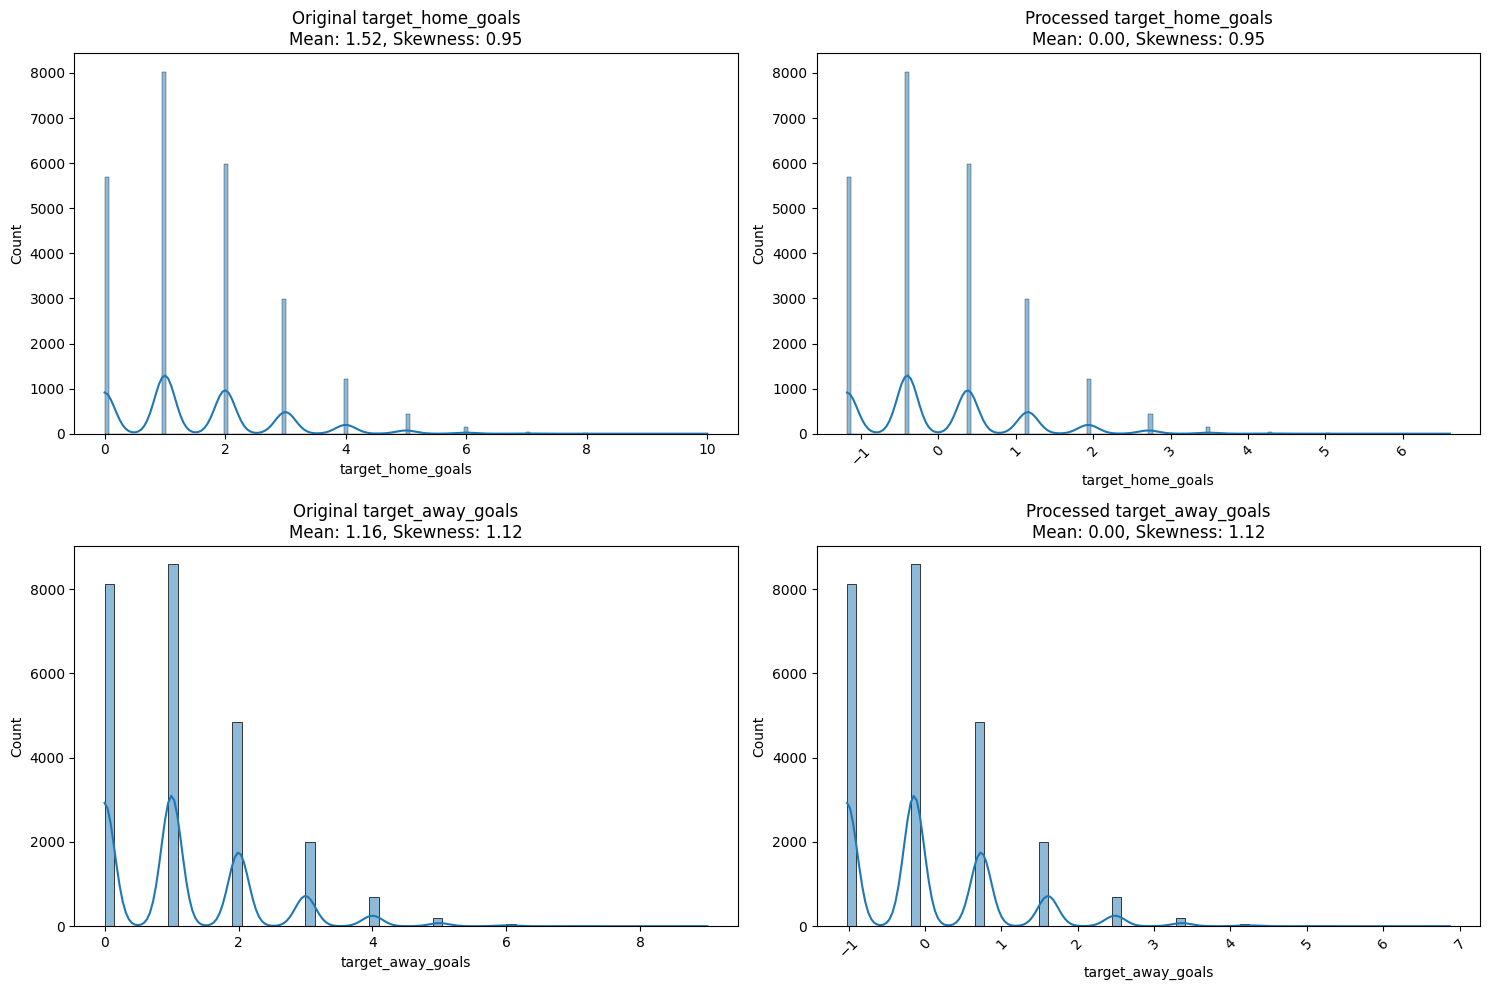

In [11]:
data.drop(columns=['away_comeback_ratio', 'away_lead_loss_ratio', 'home_comeback_ratio', 'home_lead_loss_ratio'], inplace=True)
print(data.shape[0])
preprocessor = FootballDataPreprocessor(data, sample_size=data.shape[0])
processed_data = preprocessor.preprocess_data(goal_processing_method='normalize')
preprocessor.plot_goal_distributions(preprocessor.data, processed_data)

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from typing import Dict, List, Tuple

class FootballDataNormalizer:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the normalizer with your football dataset.
        We'll store the scalers to allow for future inverse transformations if needed.
        """
        self.data = data.copy()
        self.scalers = {}
        self.label_encoders = {}
        
        # Identify different types of columns
        self.identify_column_types()
        
    def identify_column_types(self):
        """
        Categorize columns based on their content and required processing.
        """
        self.categorical_columns = []
        self.continuous_columns = []
        self.goal_columns = []
        self.date_columns = []
        
        for column in self.data.columns:
            if 'date' in column.lower():
                self.date_columns.append(column)
            elif self.data[column].dtype == 'object' or self.data[column].dtype == 'category':
                self.categorical_columns.append(column)
            elif 'goals' in column.lower():
                self.goal_columns.append(column)
            else:
                self.continuous_columns.append(column)
                
        print("Column types identified:")
        print(f"Categorical columns: {len(self.categorical_columns)}")
        print(f"Continuous columns: {len(self.continuous_columns)}")
        print(f"Goal-related columns: {len(self.goal_columns)}")
        print(f"Date columns: {len(self.date_columns)}")
    
    def process_dates(self):
        """
        Convert dates into numerical features that capture temporal information.
        """
        for column in self.date_columns:
            # Convert to datetime if not already
            self.data[column] = pd.to_datetime(self.data[column])
            
            # Extract useful temporal features
            self.data[f'{column}_year'] = self.data[column].dt.year
            self.data[f'{column}_month'] = self.data[column].dt.month
            self.data[f'{column}_day'] = self.data[column].dt.day
            self.data[f'{column}_dayofweek'] = self.data[column].dt.dayofweek
            
            # Add these new columns to continuous columns
            self.continuous_columns.extend([
                f'{column}_year', f'{column}_month',
                f'{column}_day', f'{column}_dayofweek'
            ])
            
            # Drop original date column
            self.data = self.data.drop(columns=[column])
    
    def normalize_continuous_features(self):
        """
        Apply Min-Max normalization to continuous features.
        Store scalers for potential inverse transformation.
        """
        for column in self.continuous_columns:
            scaler = MinMaxScaler()
            # Reshape for sklearn compatibility
            values = self.data[column].values.reshape(-1, 1)
            normalized_values = scaler.fit_transform(values)
            self.data[column] = normalized_values.ravel()
            self.scalers[column] = scaler
            
            print(f"Normalized {column}: Range [{self.data[column].min():.3f}, {self.data[column].max():.3f}]")
    
    def normalize_goal_features(self):
        """
        Apply specialized normalization to goal-related features.
        We use a robust scaler for goals to handle their discrete nature.
        """
        for column in self.goal_columns:
            scaler = StandardScaler()
            values = self.data[column].values.reshape(-1, 1)
            normalized_values = scaler.fit_transform(values)
            self.data[column] = normalized_values.ravel()
            self.scalers[column] = scaler
            
            print(f"Normalized {column}: Mean={self.data[column].mean():.3f}, Std={self.data[column].std():.3f}")
    
    def encode_categorical_features(self):
        """
        Encode categorical variables using Label Encoding.
        Store encoders for potential inverse transformation.
        """
        for column in self.categorical_columns:
            encoder = LabelEncoder()
            self.data[column] = encoder.fit_transform(self.data[column])
            self.label_encoders[column] = encoder
            
            print(f"Encoded {column}: {len(encoder.classes_)} unique values")
    
    def normalize_data(self) -> Tuple[pd.DataFrame, Dict]:
        """
        Complete normalization pipeline for the football dataset.
        Returns both normalized data and dictionary of transformers for inverse transformation.
        """
        print("\nStarting data normalization process...")
        
        # Step 1: Process dates
        print("\nProcessing date columns...")
        self.process_dates()
        
        # Step 2: Normalize continuous features
        print("\nNormalizing continuous features...")
        self.normalize_continuous_features()
        
        # Step 3: Handle goal-related features
        print("\nNormalizing goal-related features...")
        self.normalize_goal_features()
        
        # Step 4: Encode categorical features
        print("\nEncoding categorical features...")
        self.encode_categorical_features()
        
        # Create dictionary with transformation info
        transformers = {
            'scalers': self.scalers,
            'label_encoders': self.label_encoders
        }
        
        return self.data, transformers

# Example usage function
def normalize_football_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    """
    Normalize a football dataset with appropriate handling for different feature types.
    
    Parameters:
        data: Your original football DataFrame
    
    Returns:
        normalized_data: The processed and normalized DataFrame
        transformers: Dictionary containing the scalers and encoders used
    """
    normalizer = FootballDataNormalizer(data)
    normalized_data, transformers = normalizer.normalize_data()
    
    # Print summary statistics
    print("\nNormalization Summary:")
    print(f"Original shape: {data.shape}")
    print(f"Normalized shape: {normalized_data.shape}")
    print("\nSample of normalized data:")
    print(normalized_data.head())
    print("\nNormalized data statistics:")
    print(normalized_data.describe())
    
    return normalized_data, transformers

# Example usage:
# normalized_data, transformers = normalize_football_data(your_data)

In [13]:
normalized_data, transformers = normalize_football_data(processed_data)

Column types identified:
Categorical columns: 4
Continuous columns: 50
Goal-related columns: 16
Date columns: 1

Starting data normalization process...

Processing date columns...

Normalizing continuous features...
Normalized home_games_played: Range [0.000, 1.000]
Normalized home_wins: Range [0.000, 1.000]
Normalized home_draws: Range [0.000, 1.000]
Normalized home_losses: Range [0.000, 1.000]
Normalized home_points_per_game: Range [0.000, 1.000]
Normalized home_avg_goal_diff: Range [0.000, 1.000]
Normalized home_recent_points_per_game: Range [0.000, 1.000]
Normalized home_recent_clean_sheets: Range [0.000, 1.000]
Normalized home_shot_conversion_rate: Range [0.000, 1.000]
Normalized home_shots_on_target_ratio: Range [0.000, 1.000]
Normalized home_avg_shots_per_game: Range [0.000, 1.000]
Normalized home_avg_shots_on_target: Range [0.000, 1.000]
Normalized home_avg_possession: Range [0.000, 1.000]
Normalized home_possession_efficiency: Range [0.000, 1.000]
Normalized home_avg_corners_f

Created analysis folder: analysis_results_normalized/football_analysis_20241219_201200

Dataset Overview:
Total matches: 24,523
Number of features: 74

=== Analyzing Match Info ===
Image dimensions will be: 6660x7992 pixels at 444 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/match_info_numerical_features.png


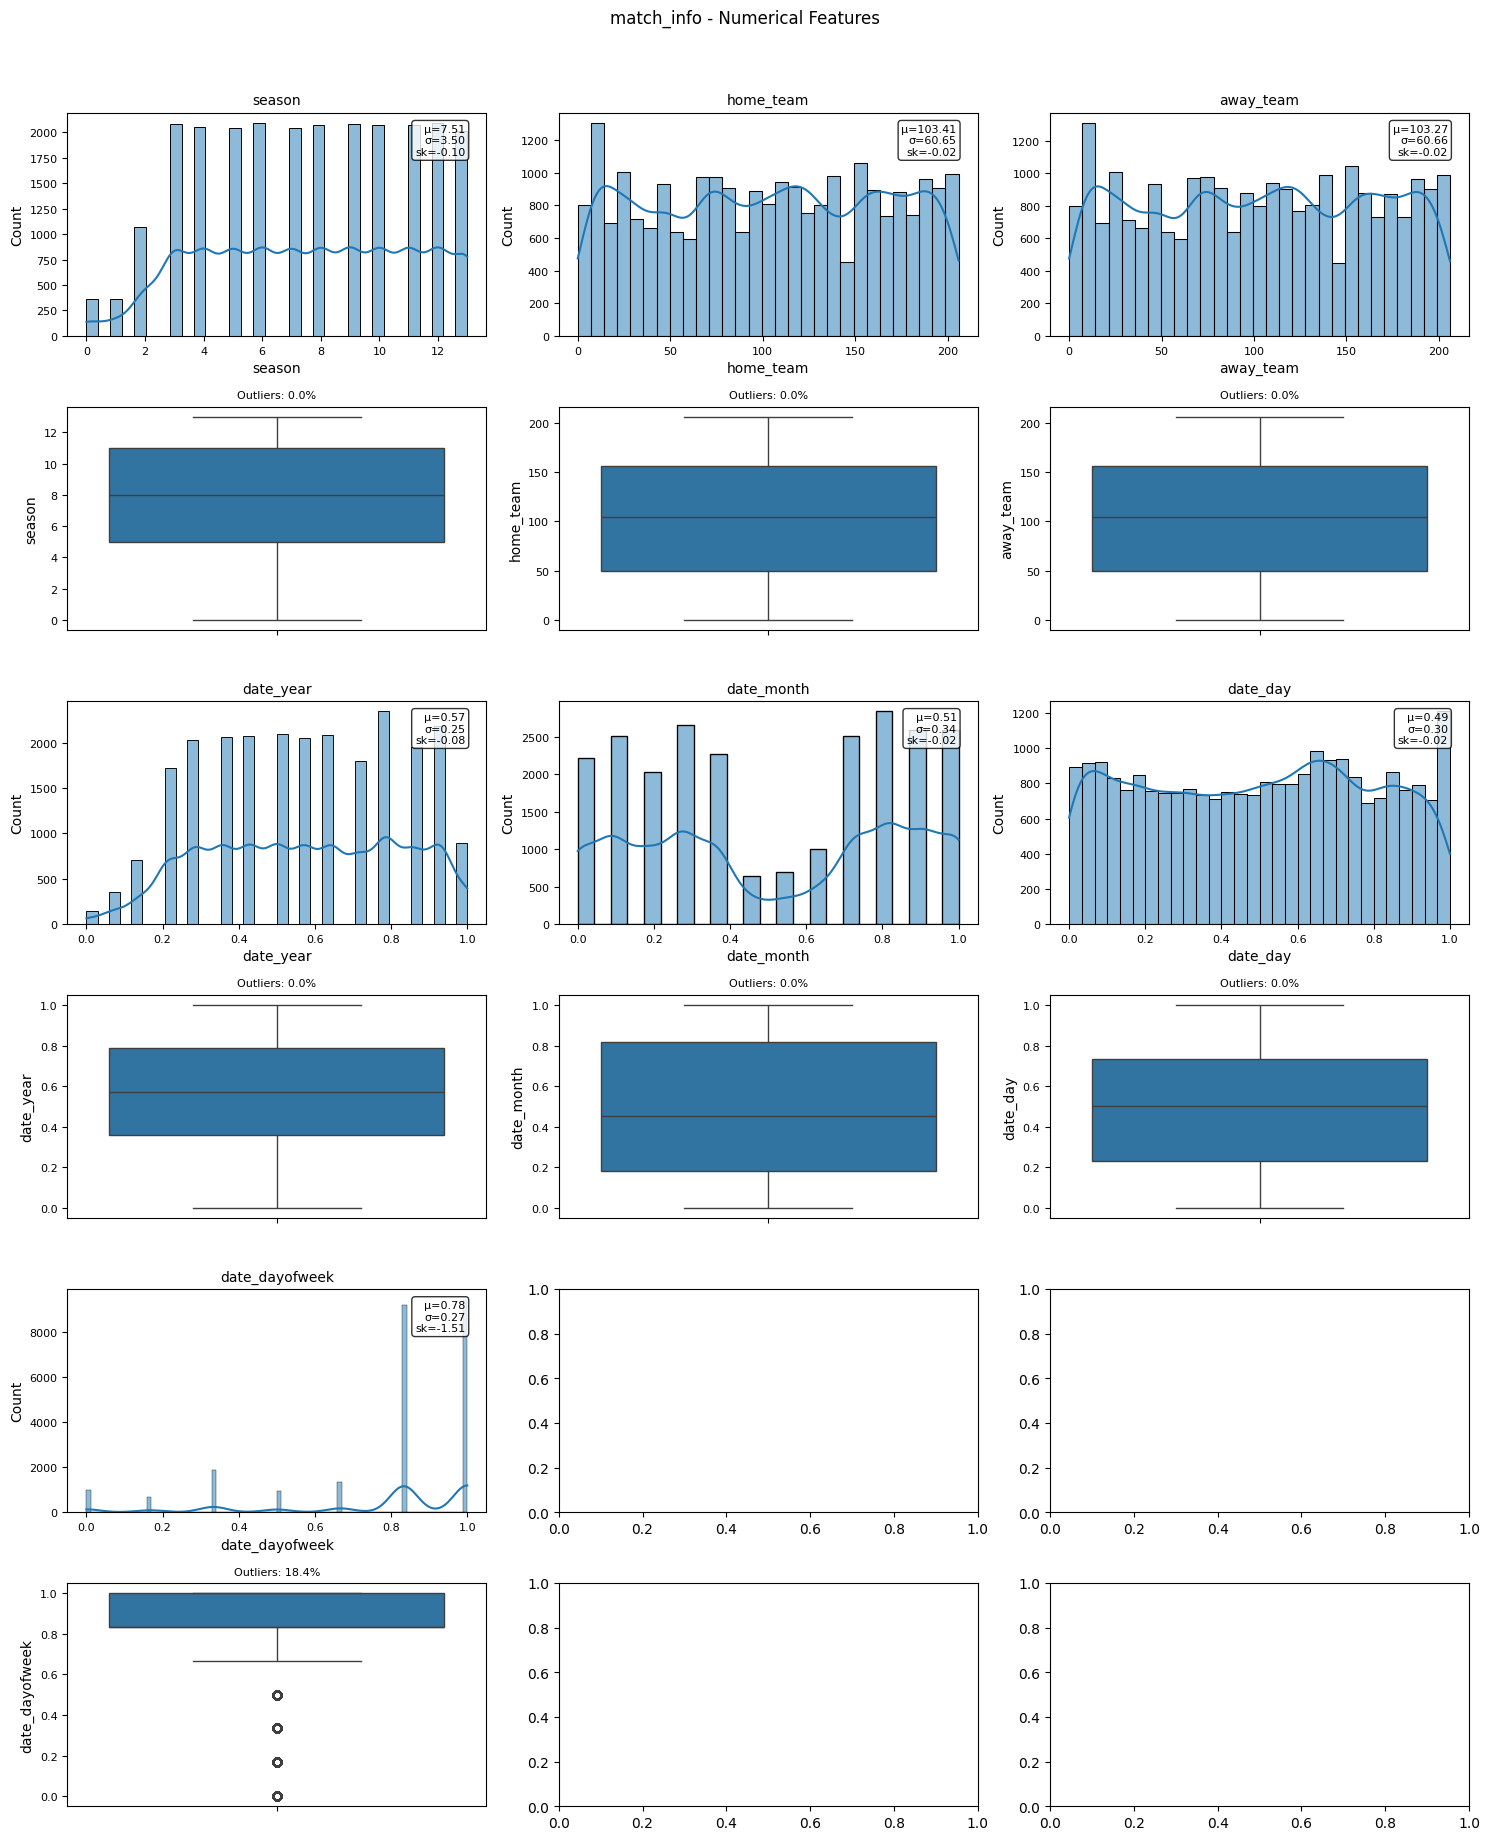


=== Analyzing Target Variables ===
Image dimensions will be: 2850x7980 pixels at 190 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/target_variables_numerical_features.png


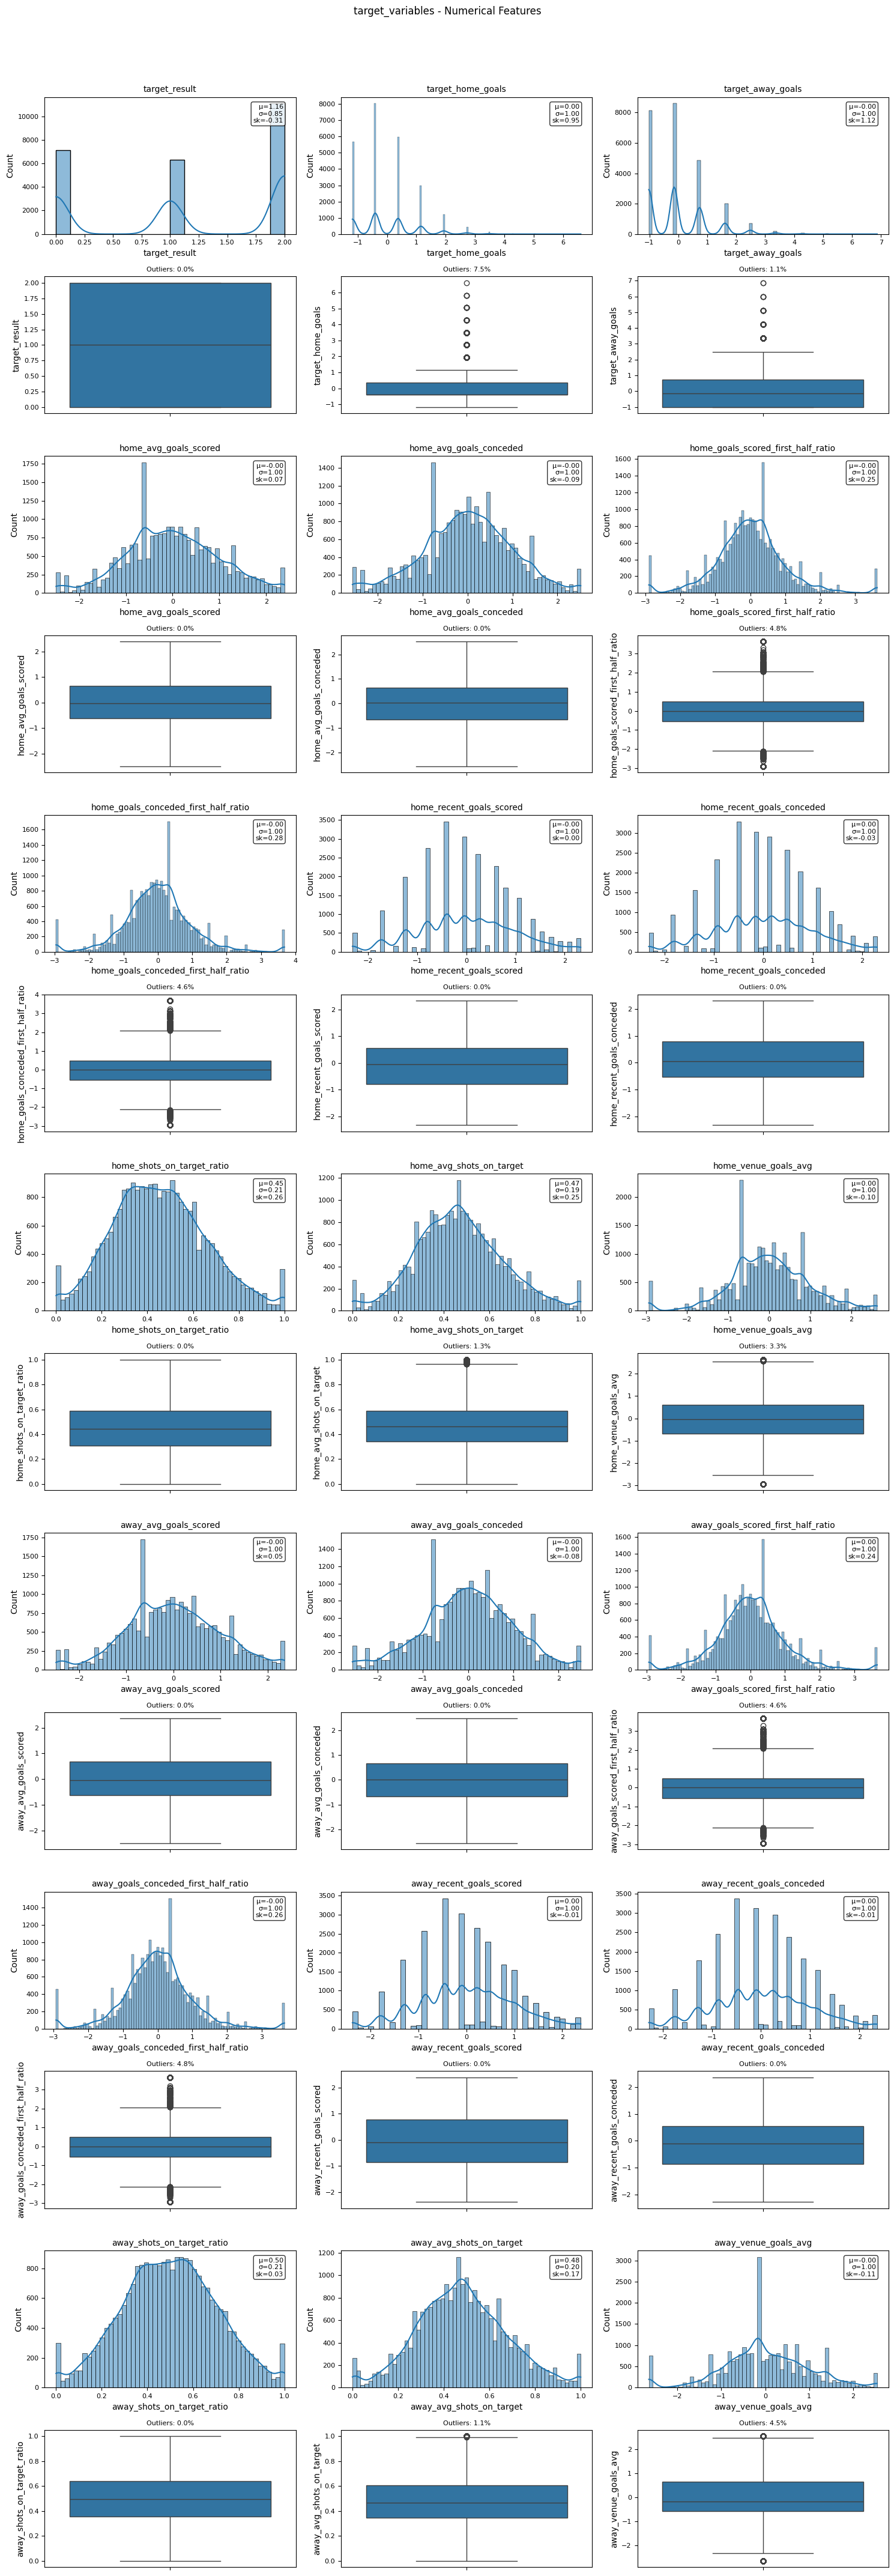


=== Analyzing Performance Metrics ===
Image dimensions will be: 3990x7980 pixels at 266 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/performance_metrics_numerical_features.png


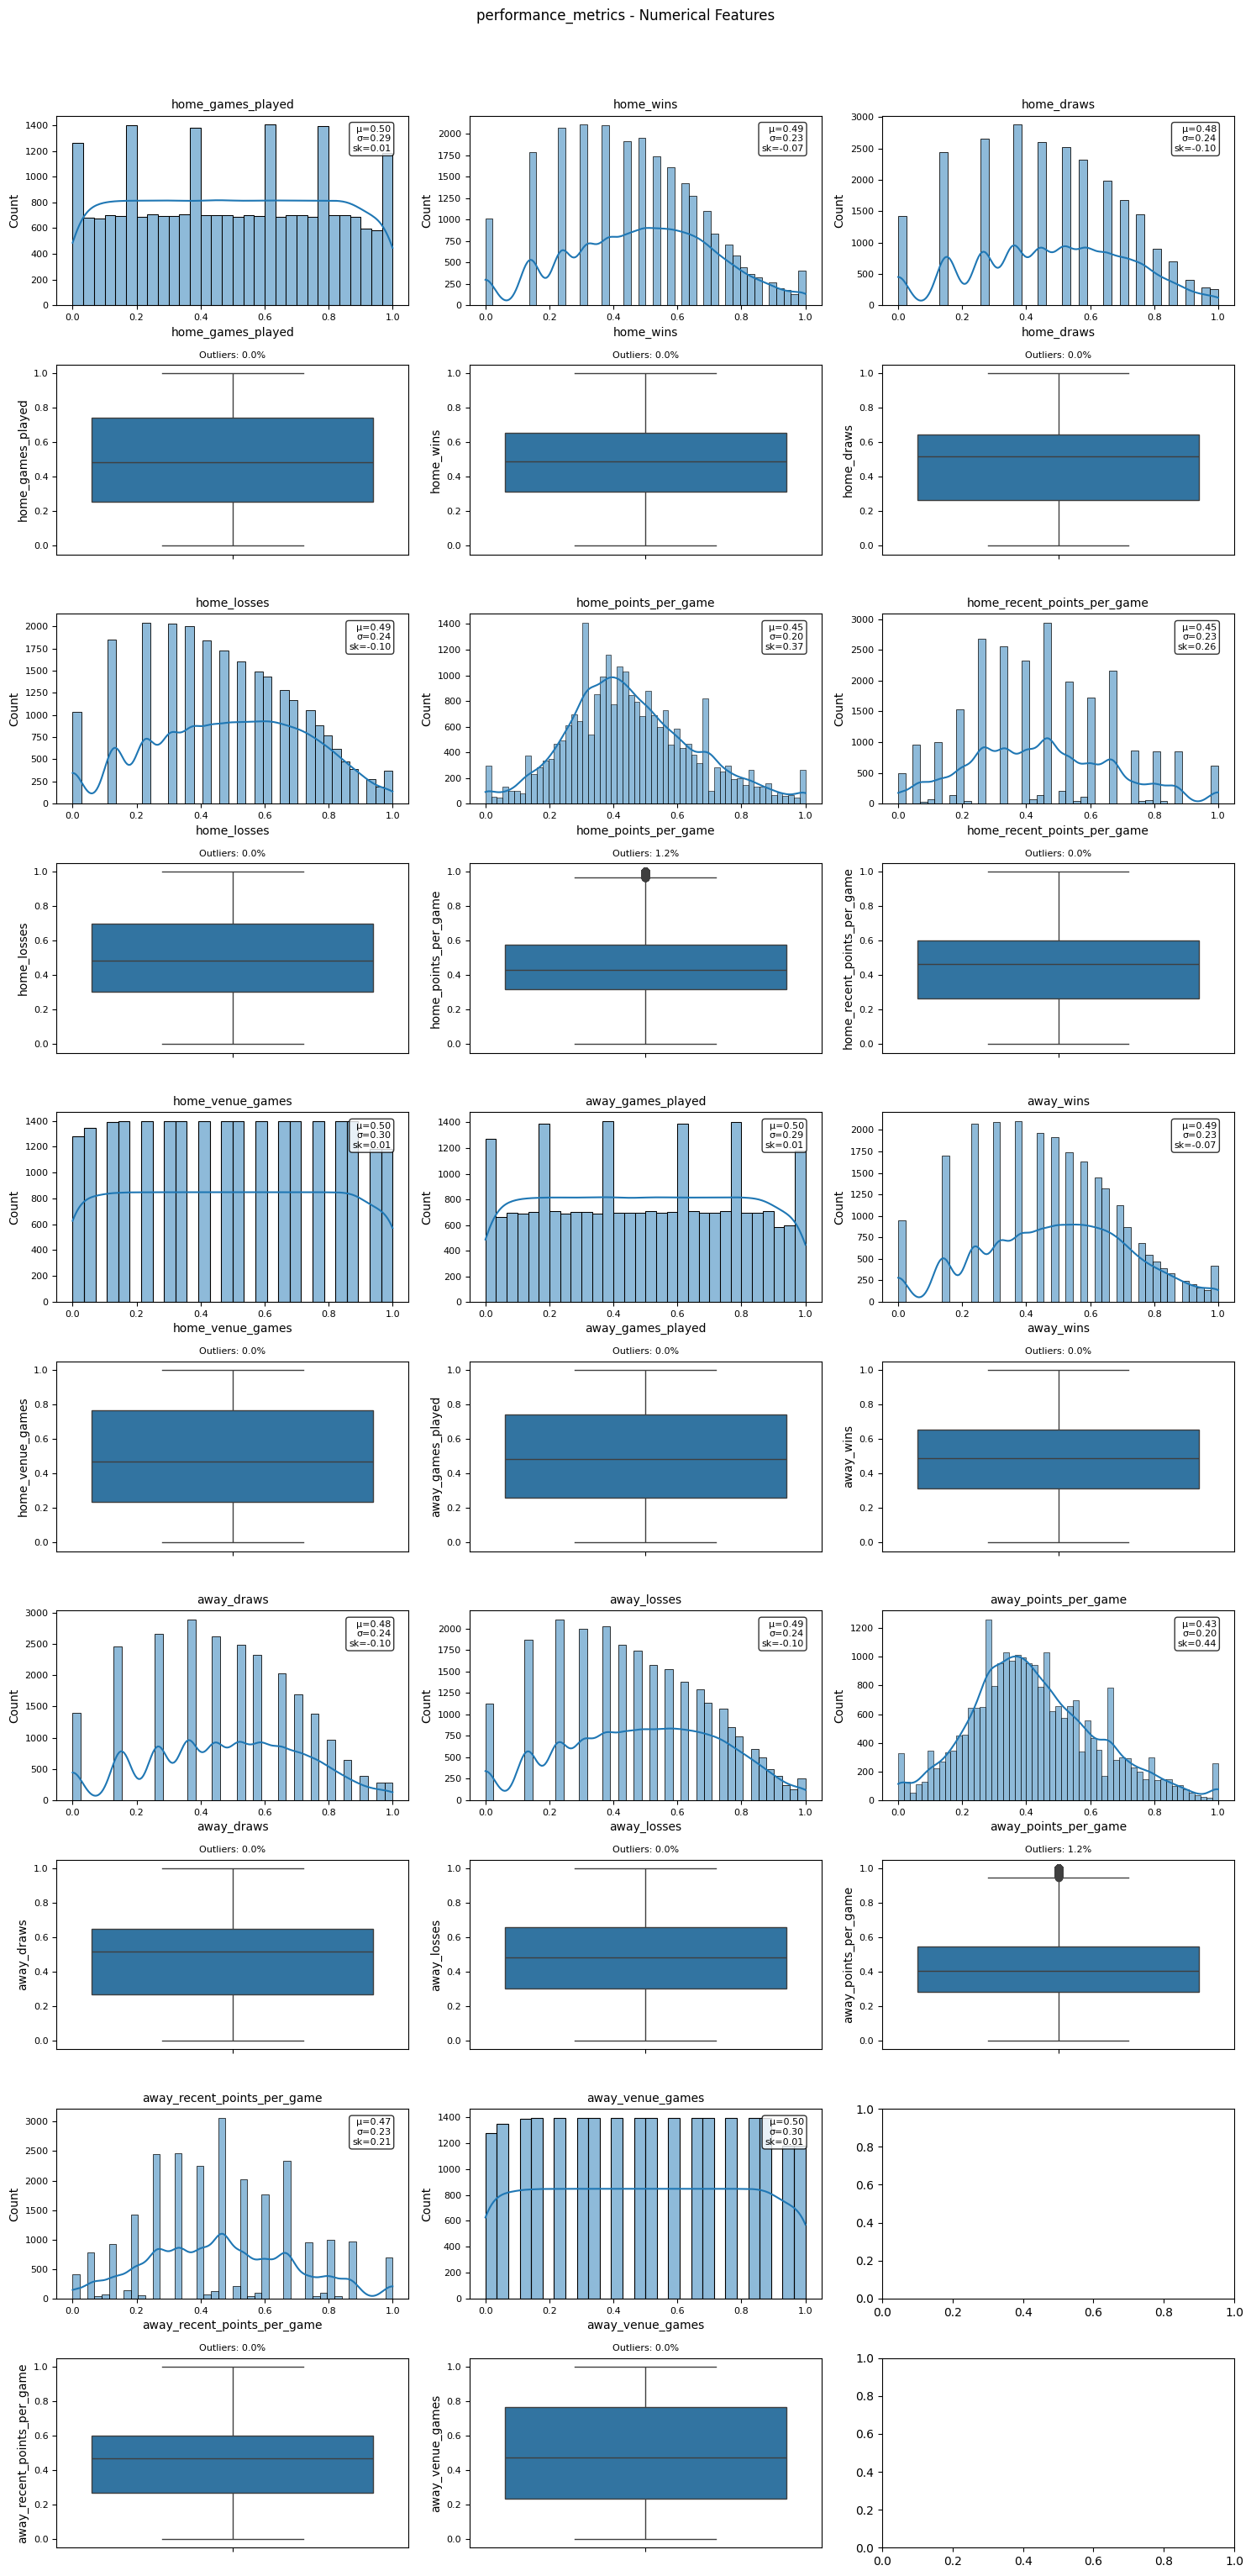


=== Analyzing Goal Stats ===
Image dimensions will be: 3990x7980 pixels at 266 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/goal_stats_numerical_features.png


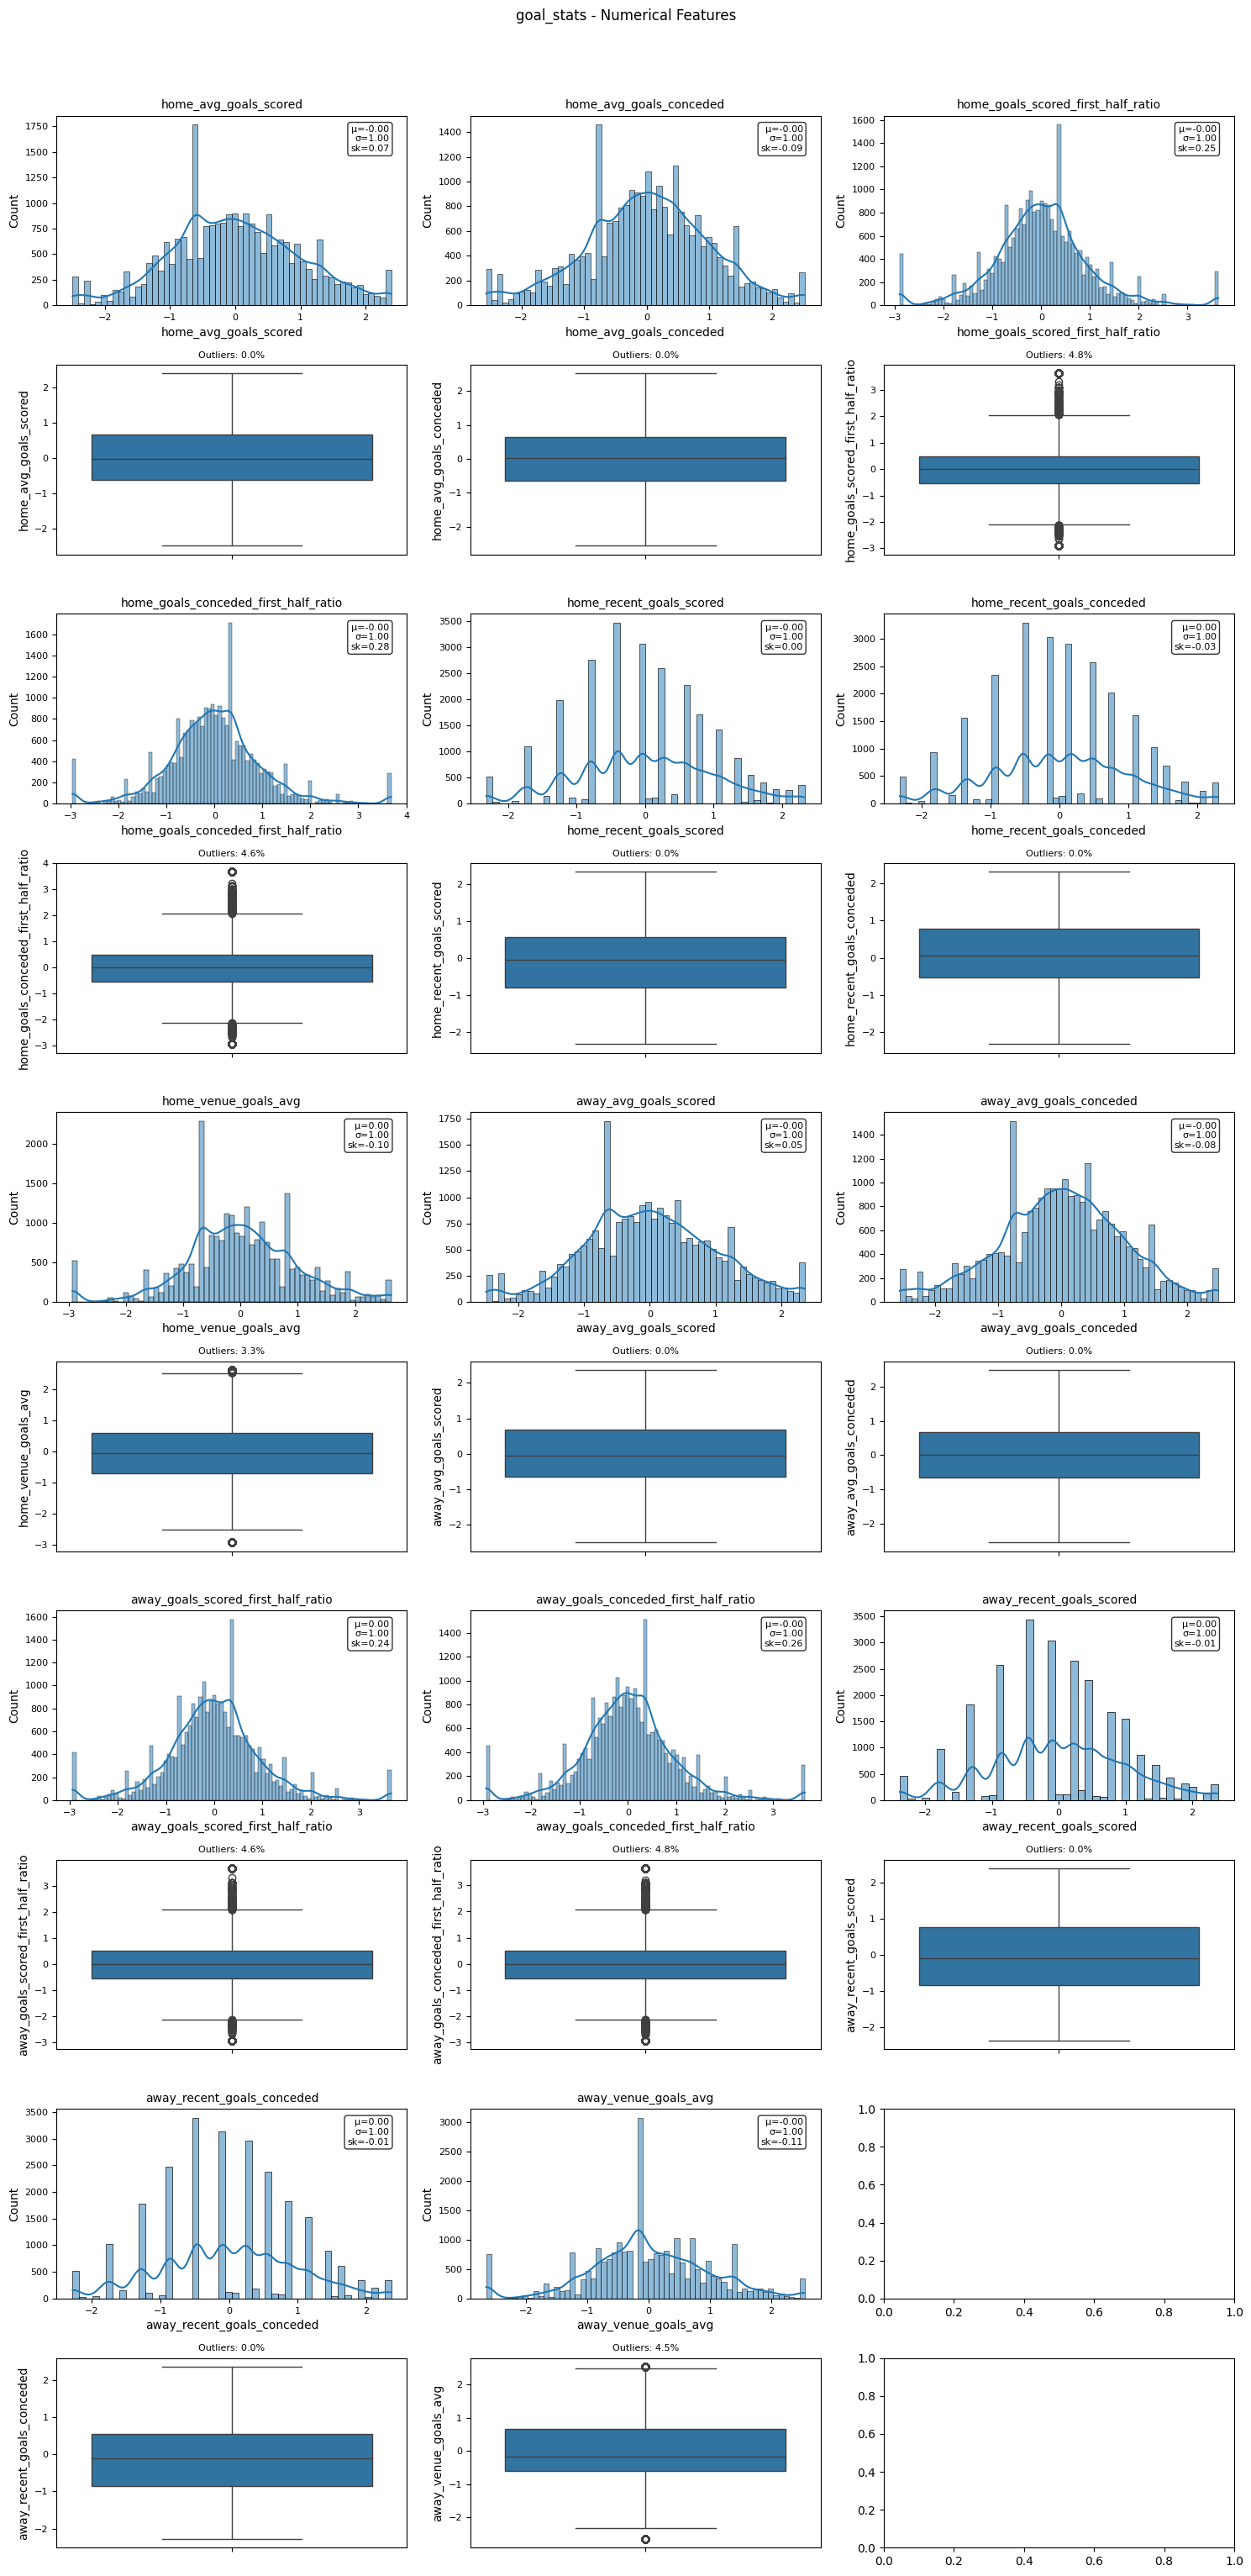


=== Analyzing Shot Stats ===
Image dimensions will be: 6660x7992 pixels at 444 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/shot_stats_numerical_features.png


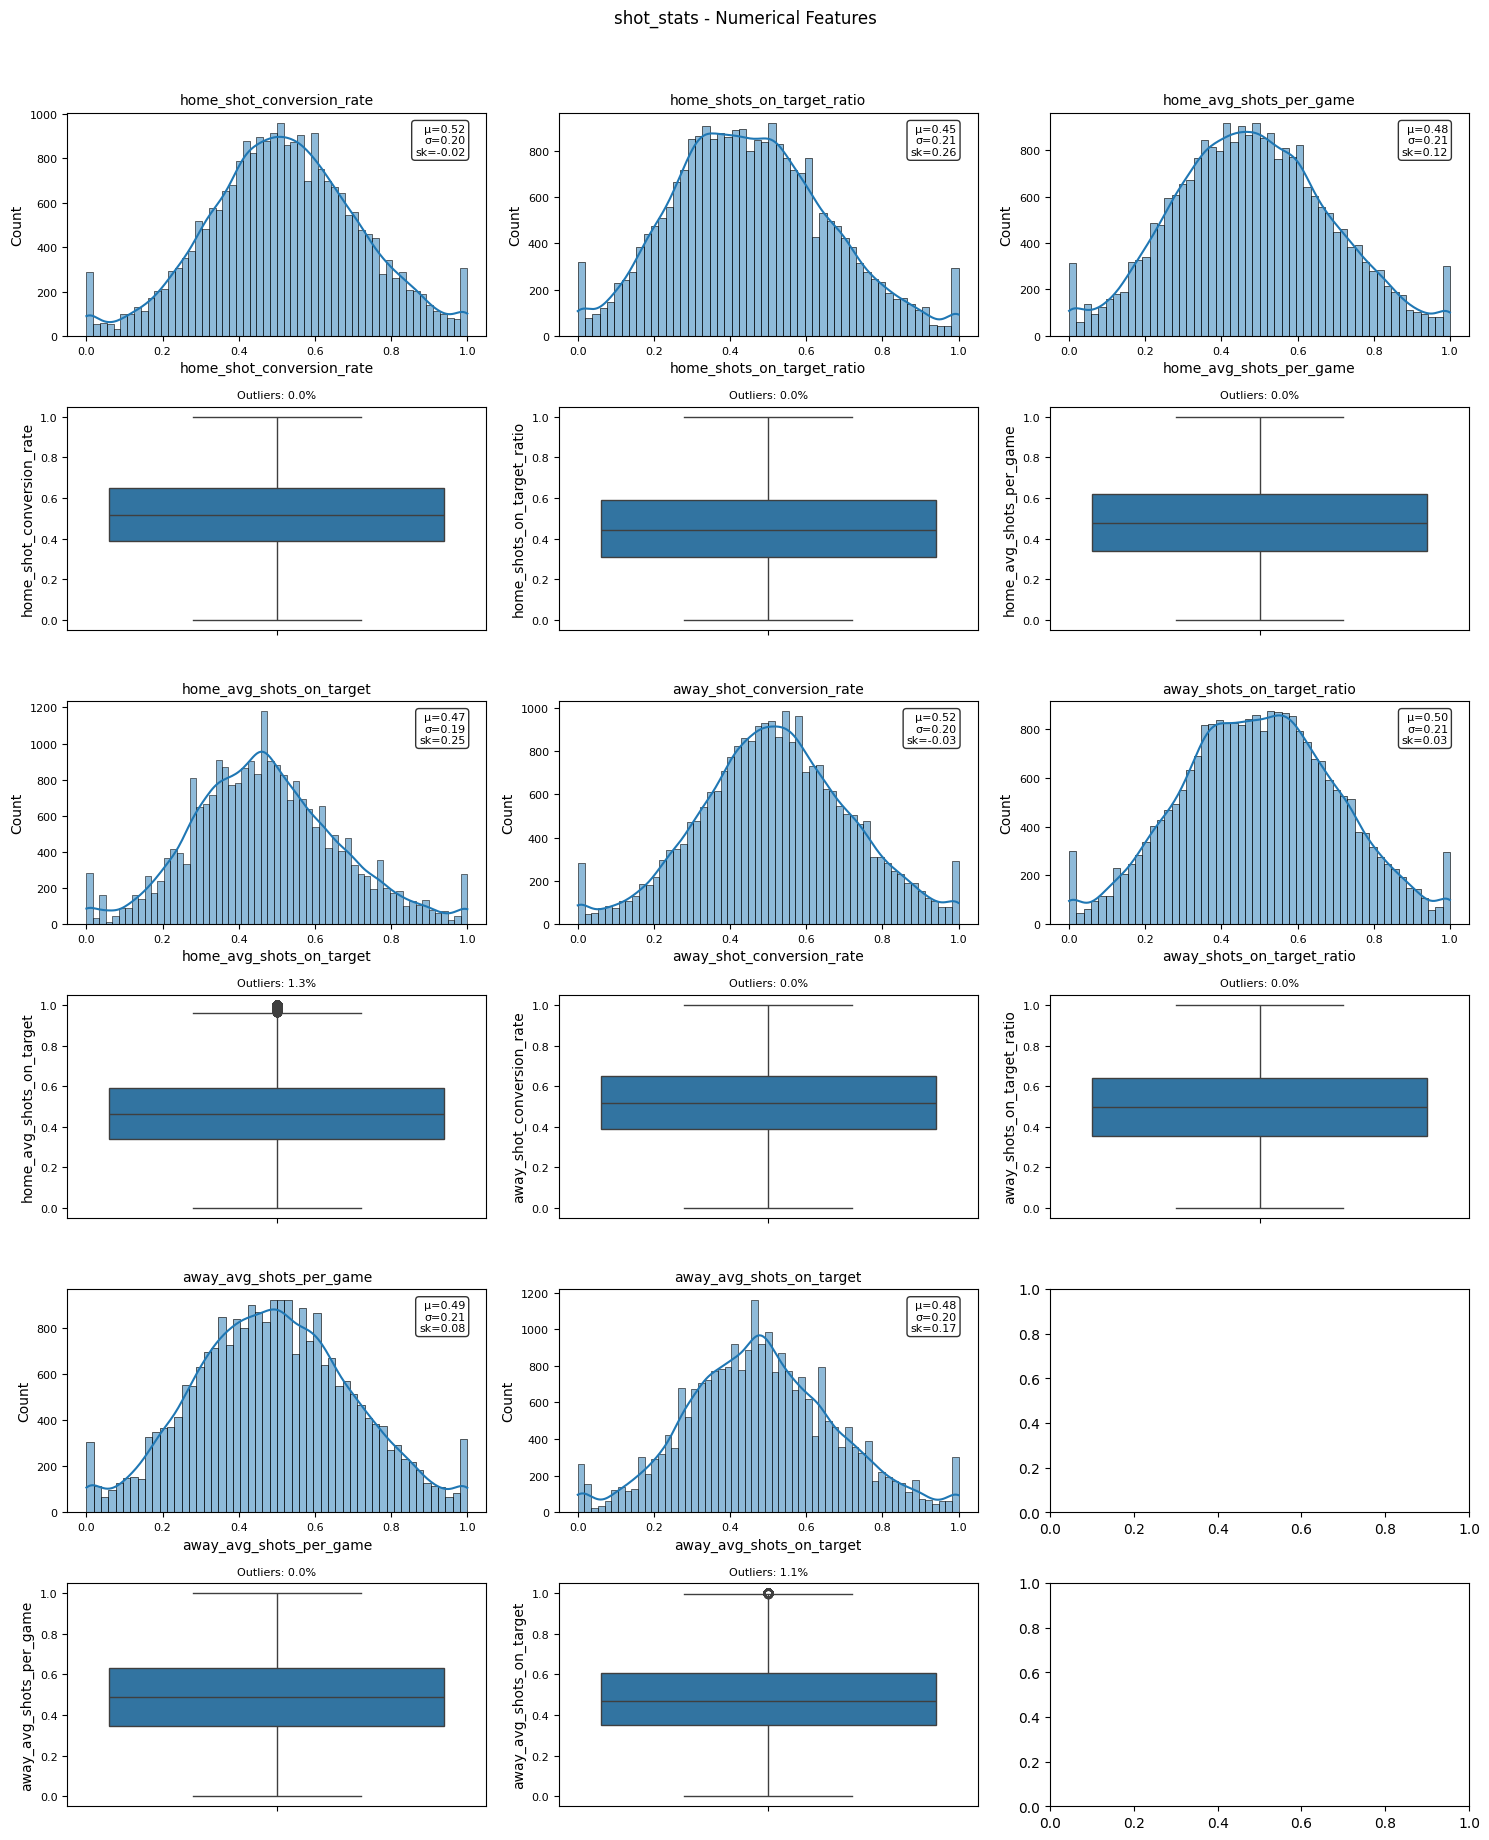


=== Analyzing Possession Stats ===
Image dimensions will be: 7995x6396 pixels at 533 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/possession_stats_numerical_features.png


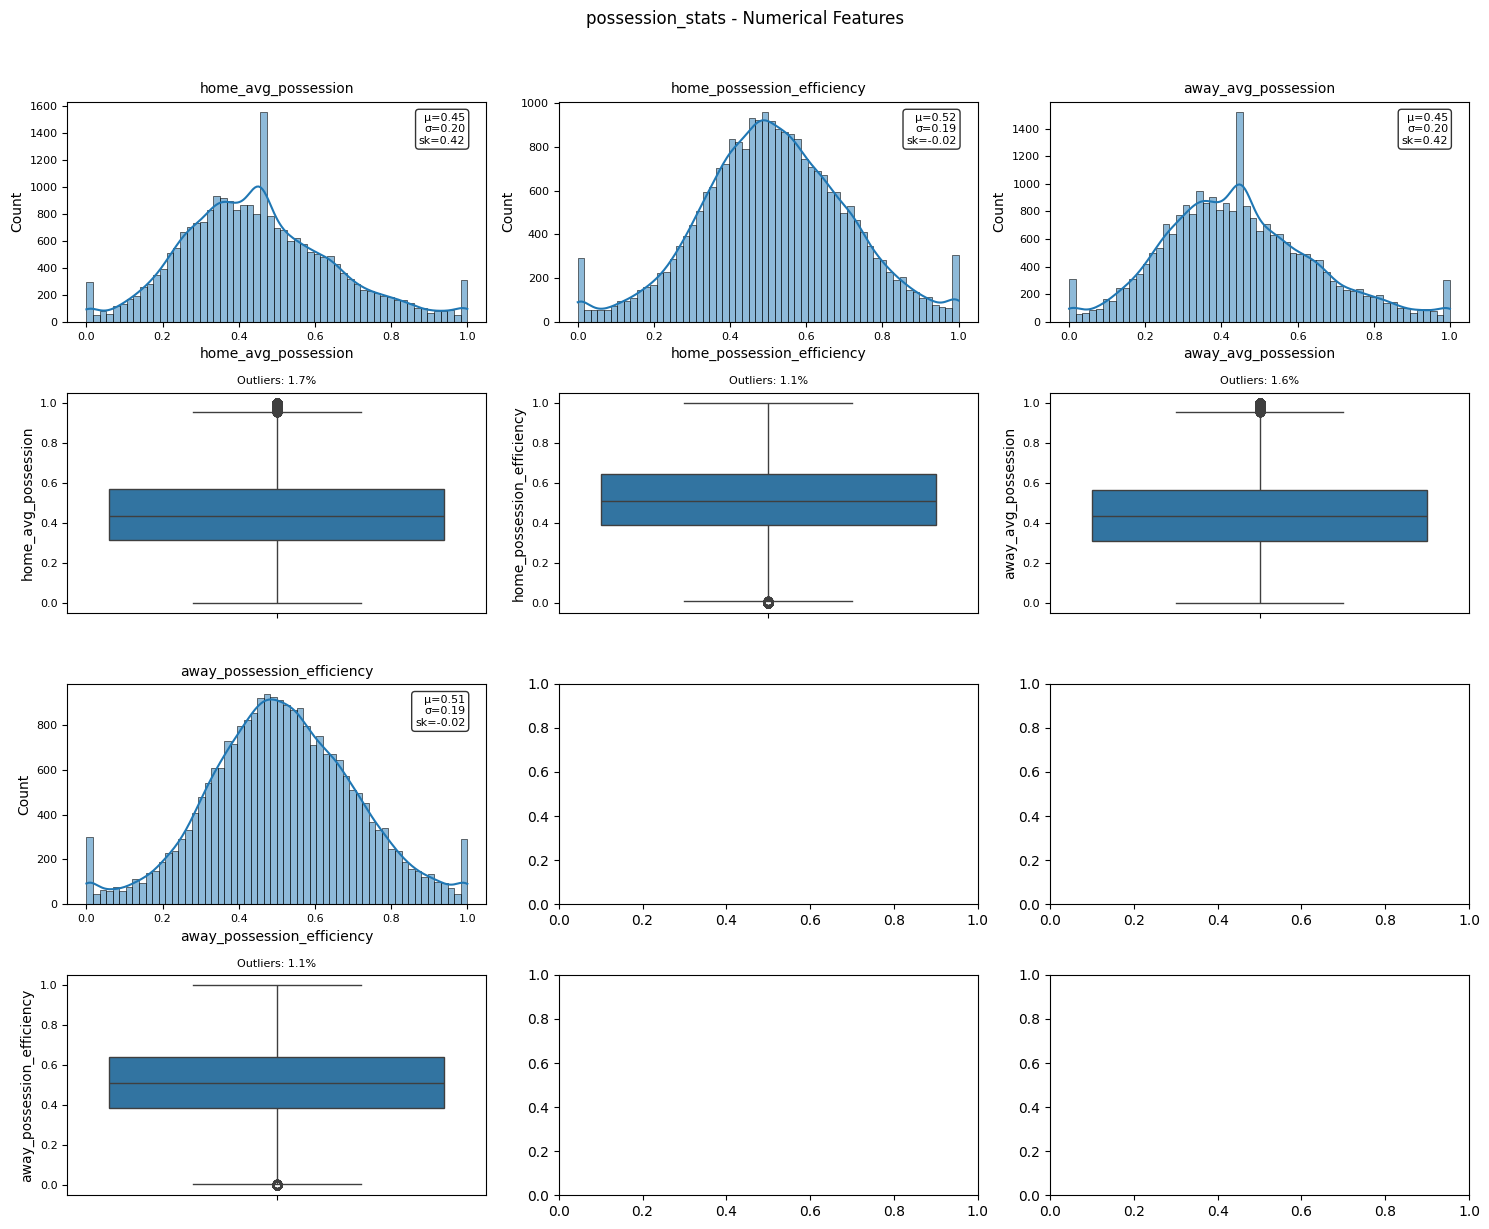


=== Analyzing Set Pieces ===
Image dimensions will be: 7995x6396 pixels at 533 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/set_pieces_numerical_features.png


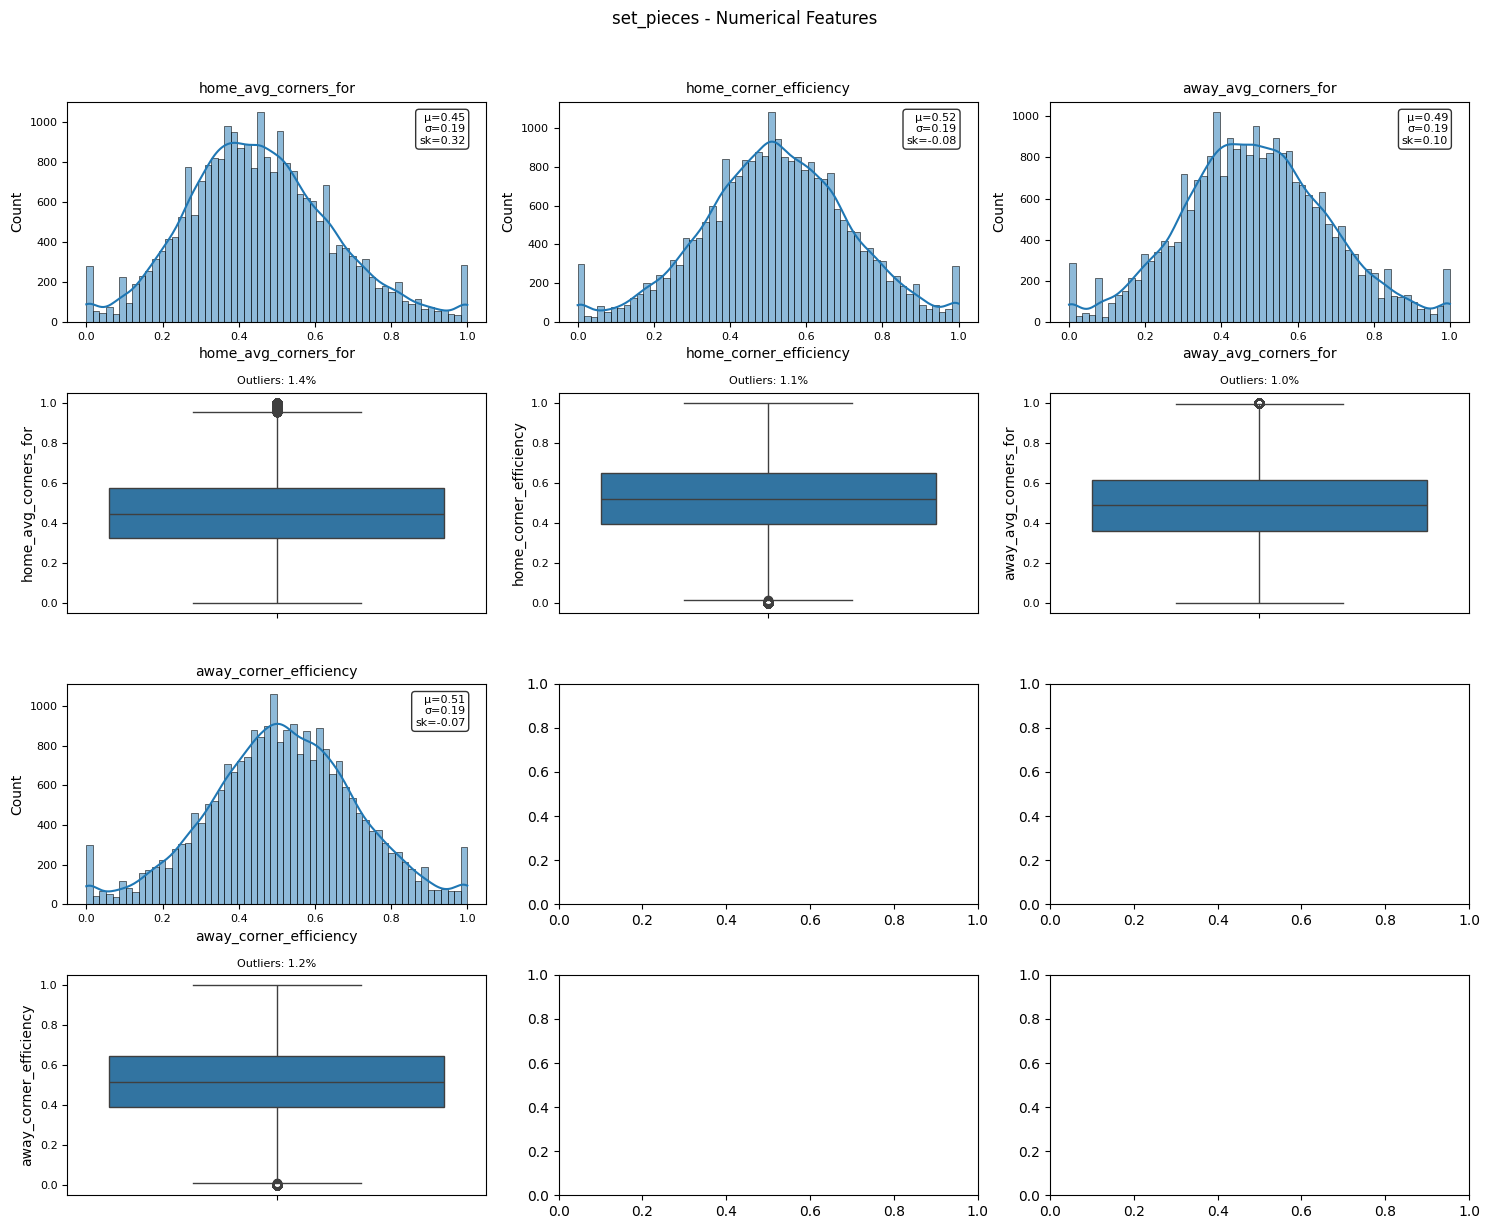


=== Analyzing Disciplinary ===
Image dimensions will be: 3990x7980 pixels at 266 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/disciplinary_numerical_features.png


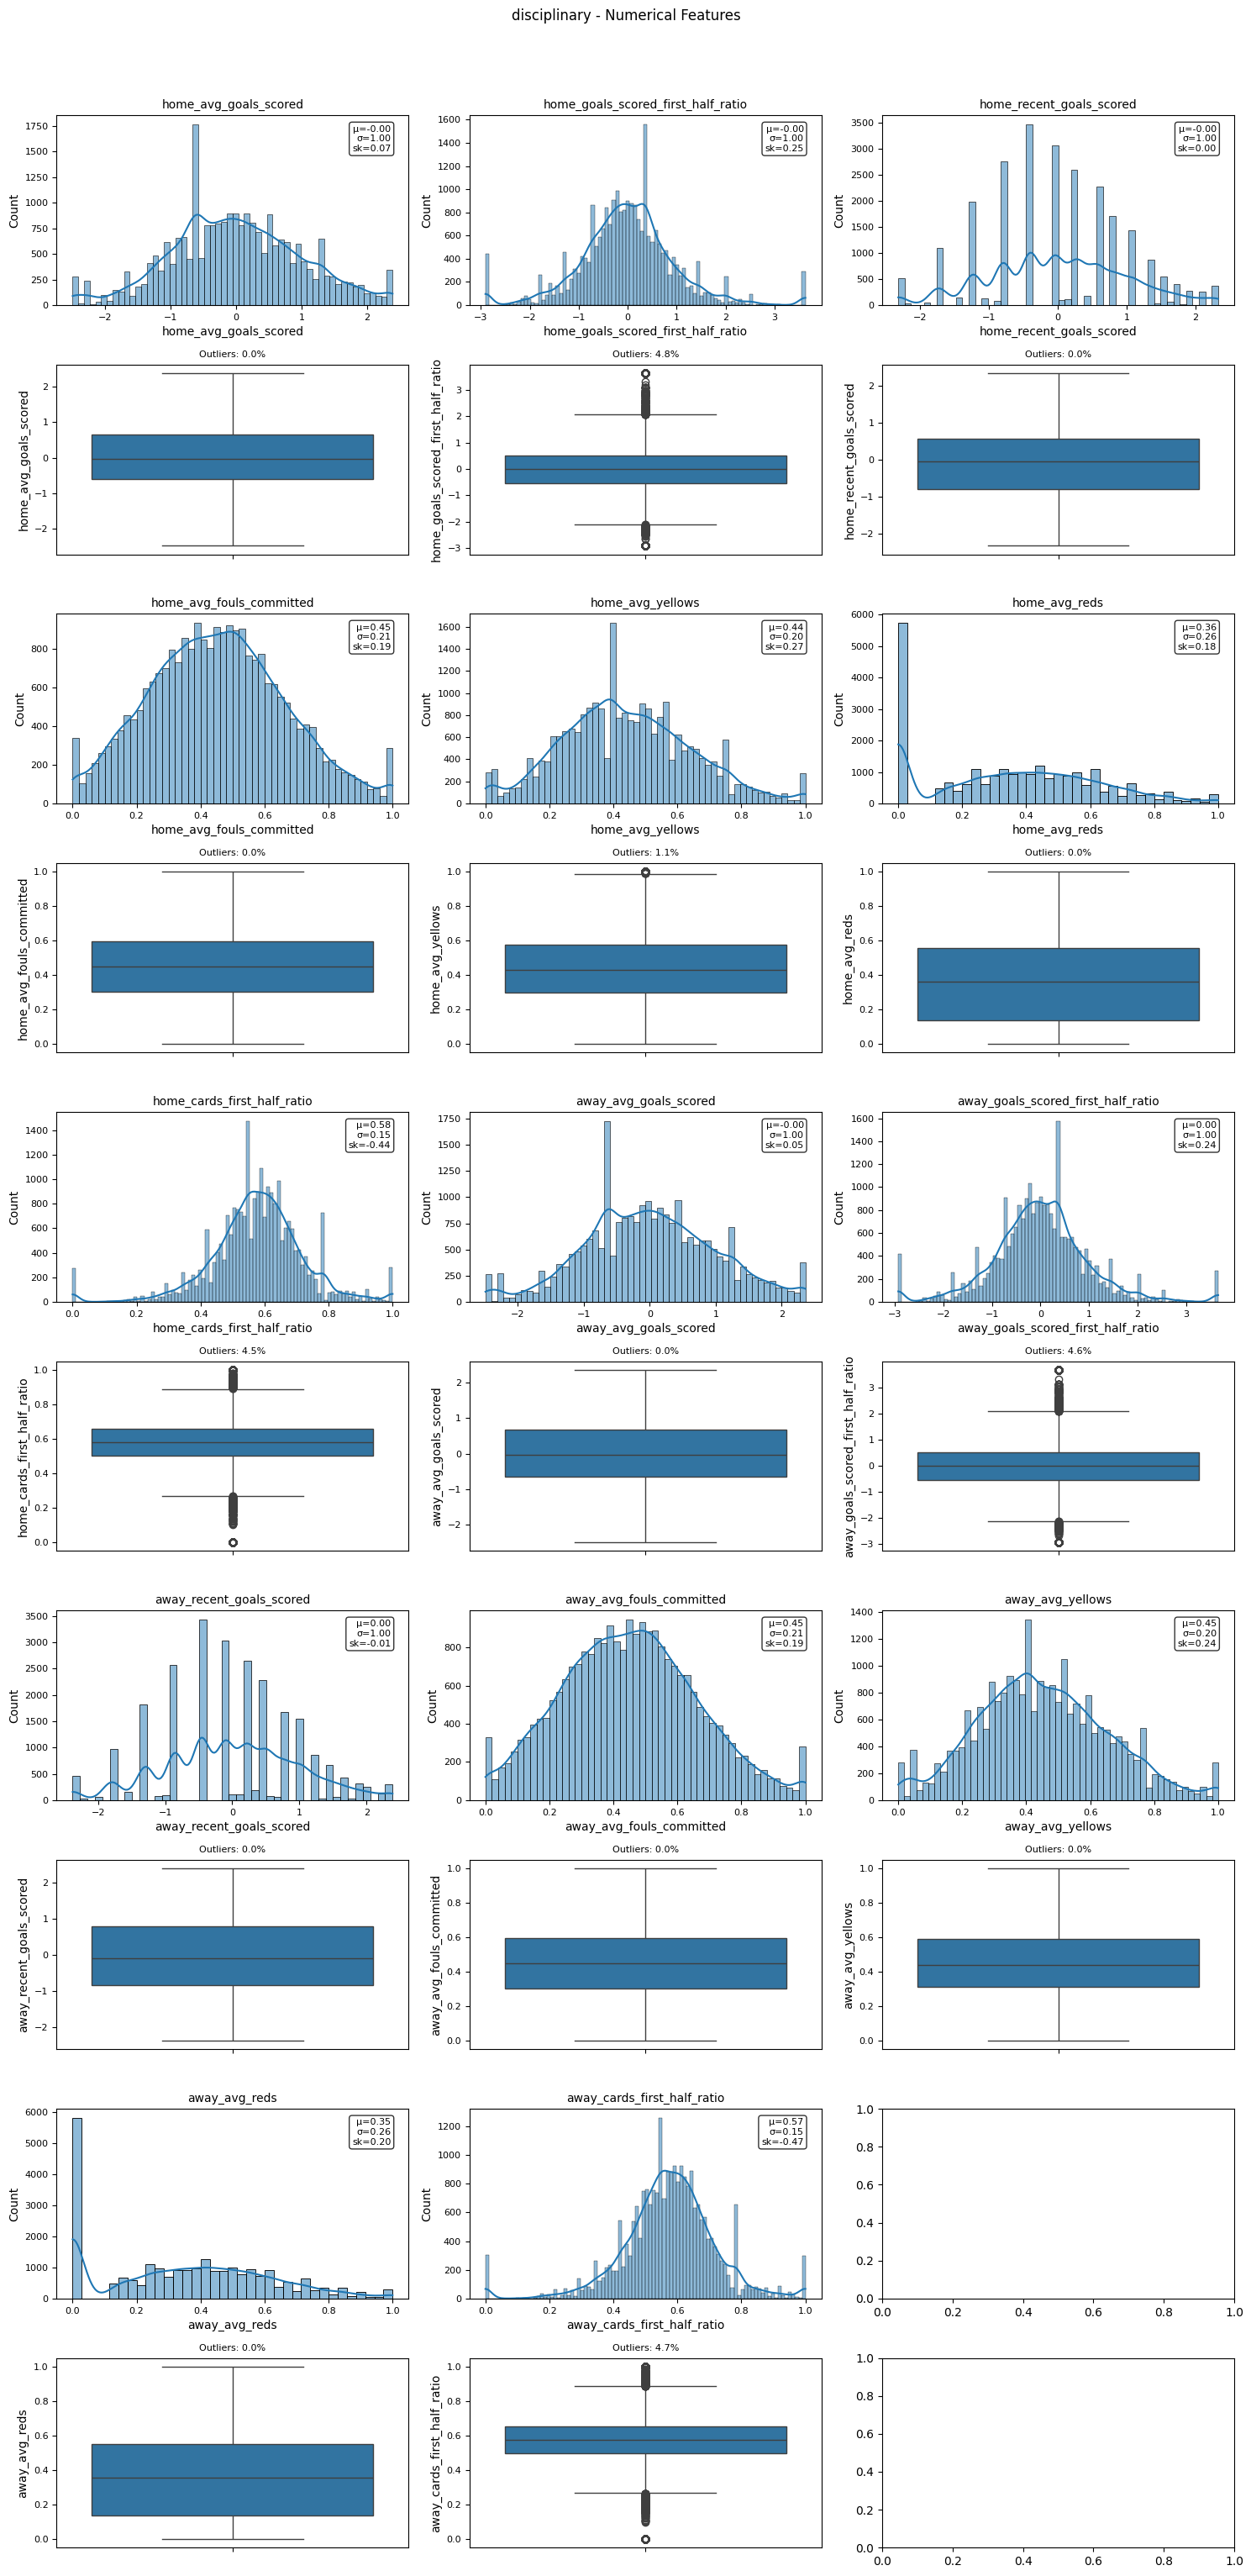


=== Analyzing Venue Specific ===
Image dimensions will be: 6660x7992 pixels at 444 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/venue_specific_numerical_features.png


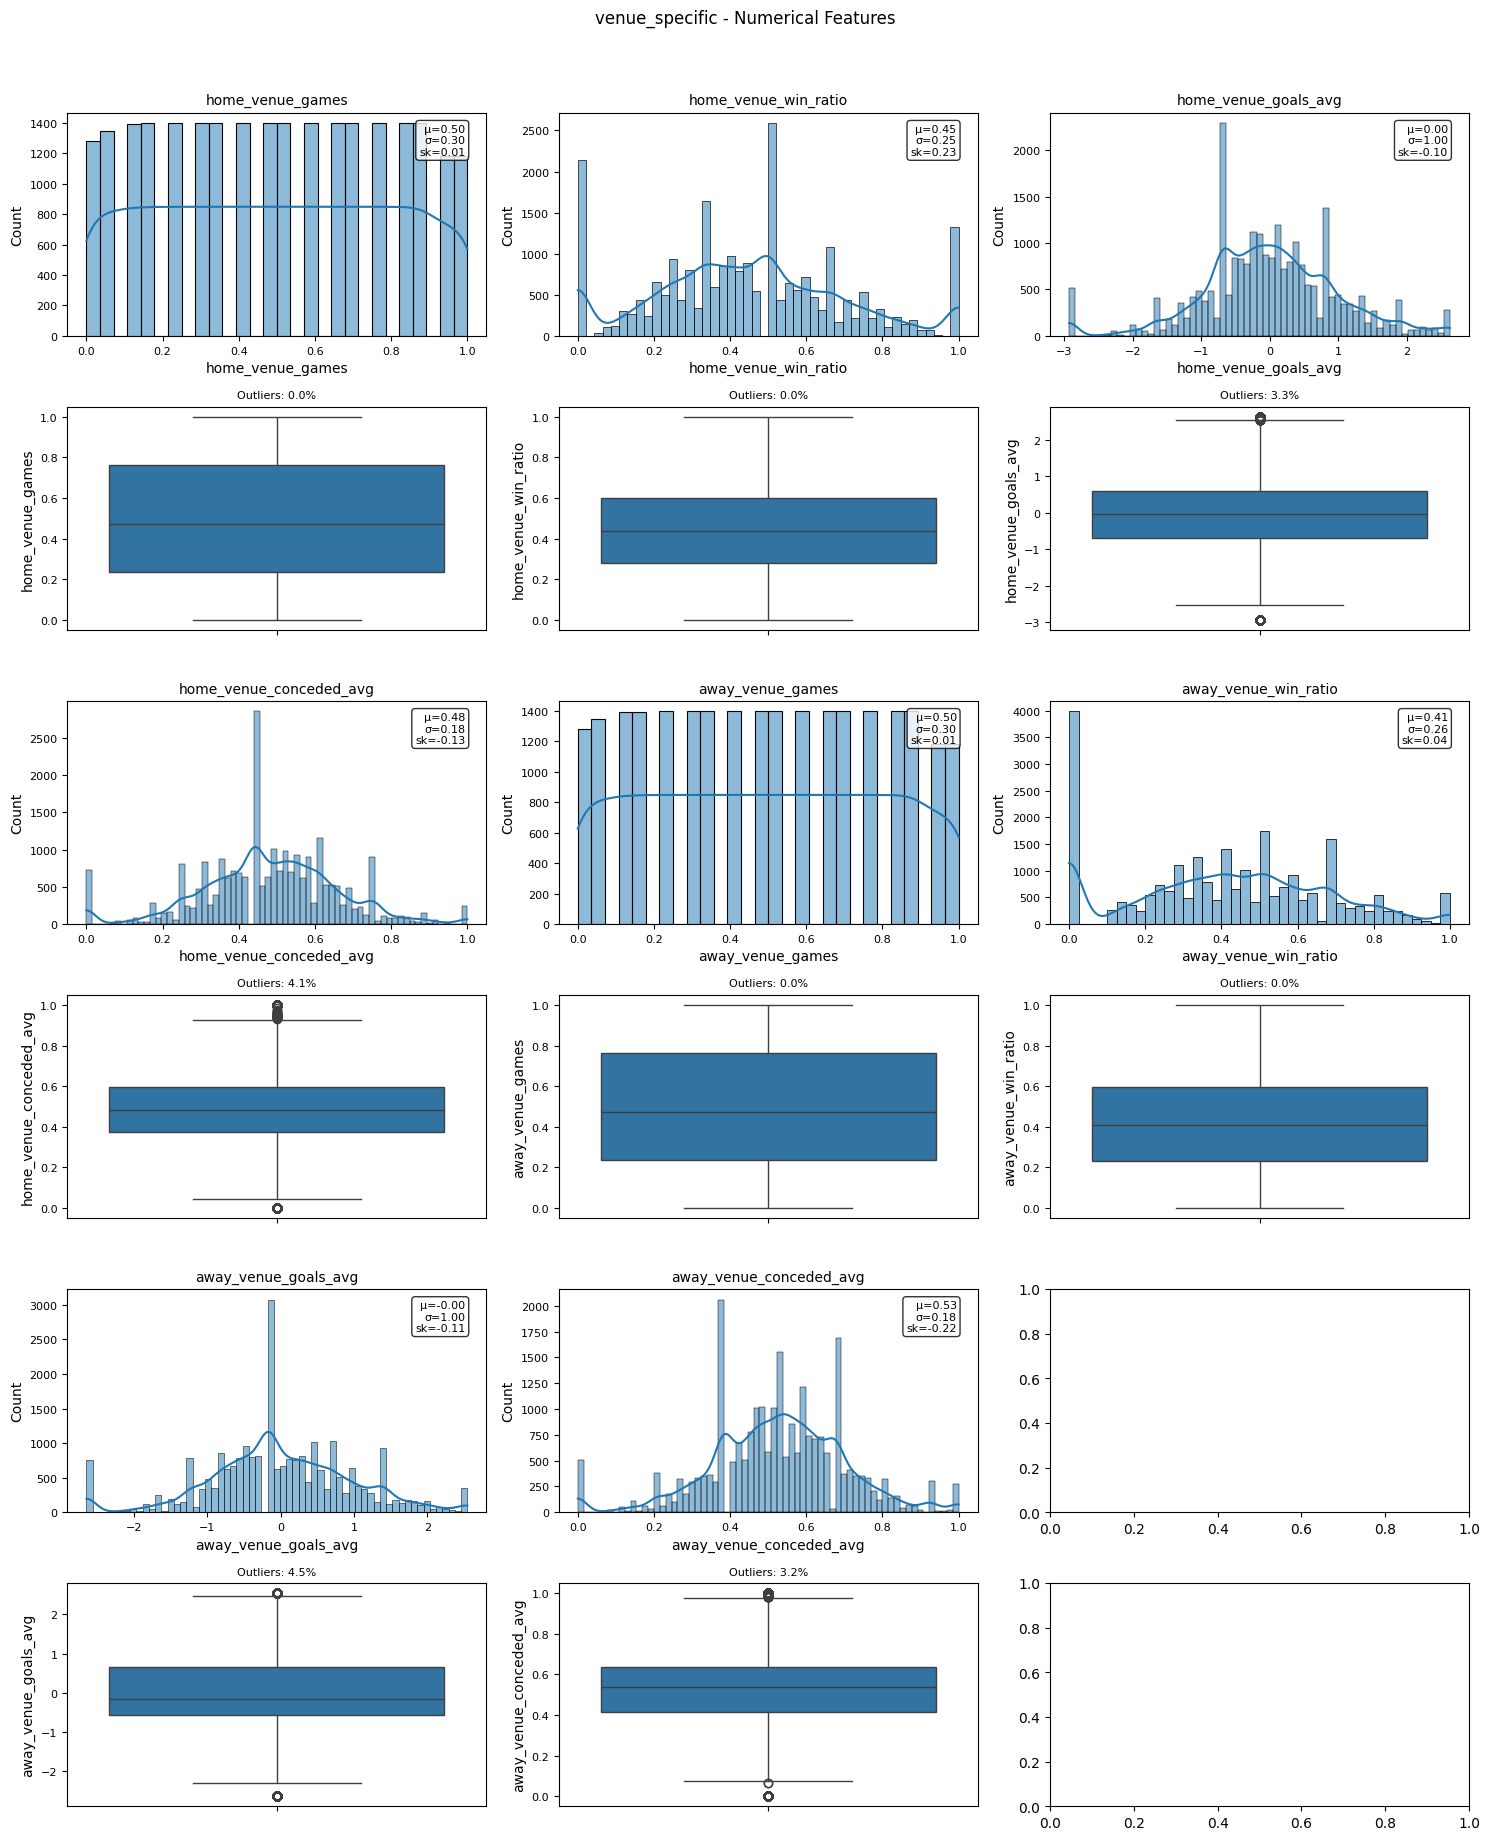


=== Analyzing Form Indicators ===
Image dimensions will be: 2220x7992 pixels at 148 DPI
Saved figure to: analysis_results_normalized/football_analysis_20241219_201200/form_indicators_numerical_features.png


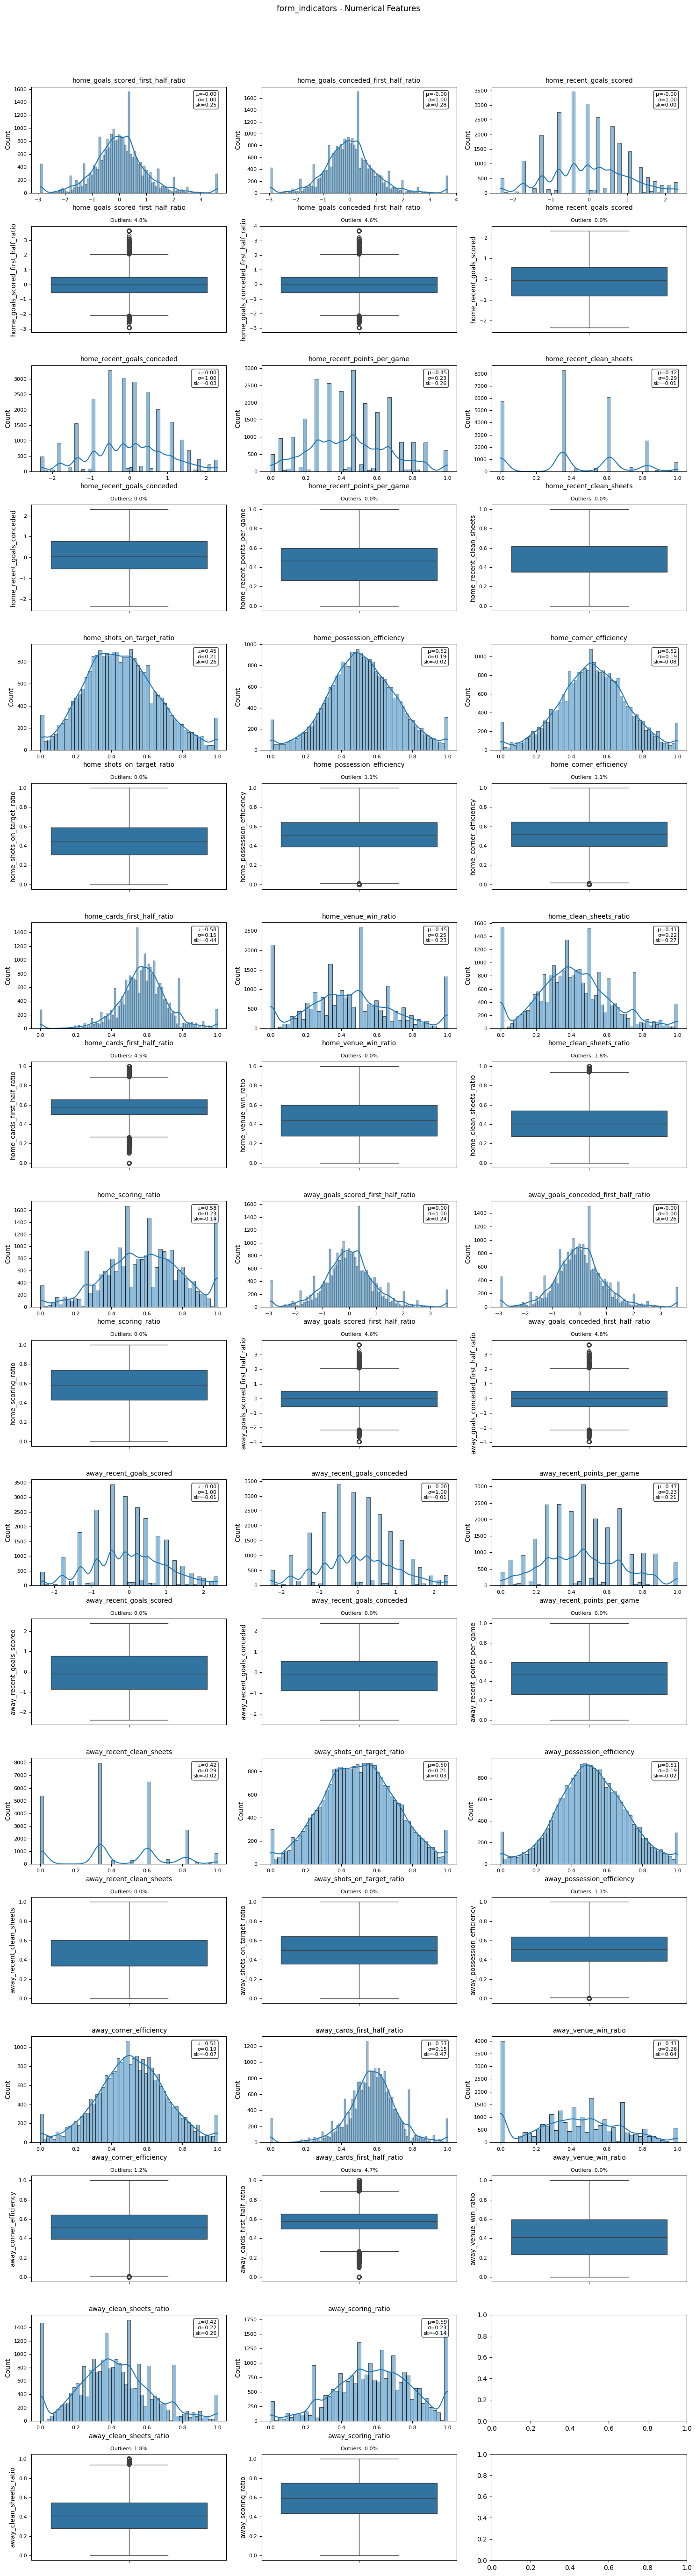

In [14]:
analyze_dataset_compact(normalized_data, save_folder="analysis_results_normalized", n_cols=3)
normalized_data.to_csv(f"{project_root}/data/all_leagues_deskewed_normalized.csv", index=False)

In [15]:
normalized_data.head()


season  home_team  away_team  target_result  target_home_goals  \
0       7         48         69              2           0.377261   
1       7        113          8              2           1.935420   
2       7        188         36              1          -0.401819   
3       7        118        113              2           2.714500   
4       7         69        188              0          -1.180898   

   target_away_goals  home_games_played  home_wins  home_draws  home_losses  \
0          -1.019154           0.000000   0.140686    0.000000     0.131088   
1          -1.019154           0.000000   0.140686    0.151444     0.000000   
2          -0.142401           0.000000   0.140686    0.000000     0.131088   
3          -1.019154           0.028571   0.238672    0.151444     0.000000   
4           1.611105           0.028571   0.140686    0.151444     0.131088   

   ...  away_venue_games  away_venue_win_ratio  away_venue_goals_avg  \
0  ...               0.0                   0.0             -0.164719   
1  ...               0.0                   0.0             -2.651330   
2  ...               0.0                   1.0              2.547006   
3  ...               0.0                   0.0              2.547006   
4  ...               0.0                   1.0              1.392945   

   away_venue_conceded_avg  away_clean_sheets_ratio  away_scoring_ratio  \
0                 0.383162                     0.75                1.00   
1                 0.383162                     0.00                0.25   
2                 0.676972                     0.00                0.25   
3                 0.924558                     1.00                1.00   
4                 0.000000                     0.50                1.00   

   date_year  date_month  date_day  date_dayofweek  
0        0.5    0.636364  0.866667        1.000000  
1        0.5    0.636364  0.866667        1.000000  
2        0.5    0.636364  0.866667        1.000000  
3        0.5    0.727273  0.266667        0.833333  
4        0.5    0.727273  0.266667        0.833333  

[5 rows x 74 columns]